<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b> </b></font>
   
 Для просмотра получившегося исследования нейронной сети переходим в пункт 3.1.  
    В процессе построения не отпускала мысль о логарифмотизации признаков. Родилась идея с чистого датасета написать еще одно исследование по построению и улучшению нейронной сети, с учетом твоих советов. Переходим в пункт 4.  
    Обе модели преодолели порог в RMSE=4500.  
    На данном датасете будет более актуальна вторая модель.

</div>

***Прогнозирование температуры звезды***

Нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

    Закон смещения Вина.
    Закон Стефана-Больцмана.
    Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Описание данных:**

Характеристики

  * Относительная светимость L/Lo — светимость звезды относительно Солнца.
  * Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
  * Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
  * Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
  * Тип звезды.
    
| Тип звезды | Номер, соответствующий типу |
| :--- | :---: |
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |

  * Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

**Цель проекта:**

В проекте необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.
Метрика RMSE не должна превышать 4500.

Целевой признак содержит числовой диапазон значений, следовательно исследование сводится к построению модели, решающей задачу регрессии.

**План исследования:**

   1. Загрузка и обзор данных.  
   2. Предобработка и анализ данных данных.  
   3. Построение базовой нейросети.  
   4. Улучшение нейросети.  
   5. Вывод.    

## Загрузка данных

### Откроем и сохраним файл данных

Импортируем нужные библиотеки

In [1]:
!pip install -q phik

In [2]:
import numpy as np
import pandas as pd
import random
import os

import warnings
import joblib
from time import time

import itertools
from typing import Tuple
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

import phik
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error



Задание случайных величин:    

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

RANDOM_STATE = 42

In [4]:
# Открываем и сохраняем файл Churn.csv в датафрейм из директории или по ссылке:

import os

pth1 = '/datasets/6_class.csv'
pth2 = r'C:\Users\HGFDVB-328746583\Desktop\DS\6_class.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

### Изучим общую информацию о датафрейме

Выведение на экран первых 10 и 5 последних строк набора данных:

In [5]:
data.head(25)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.17000,16.120,0,Red
1,1,3042,0.000500,0.15420,16.600,0,Red
2,2,2600,0.000300,0.10200,18.700,0,Red
3,3,2800,0.000200,0.16000,16.650,0,Red
4,4,1939,0.000138,0.10300,20.060,0,Red
5,5,2840,0.000650,0.11000,16.980,0,Red
6,6,2637,0.000730,0.12700,17.220,0,Red
7,7,2600,0.000400,0.09600,17.400,0,Red
8,8,2650,0.000690,0.11000,17.450,0,Red
9,9,2700,0.000180,0.13000,16.050,0,Red


In [6]:
data.tail()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
235,235,38940,374830.0,1356.0,-9.93,5,Blue
236,236,30839,834042.0,1194.0,-10.63,5,Blue
237,237,8829,537493.0,1423.0,-10.73,5,White
238,238,9235,404940.0,1112.0,-11.23,5,White
239,239,37882,294903.0,1783.0,-7.80,5,Blue


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [8]:
data.describe()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


***Вывод:***

- В датасете 7 столбцов и 240 записей. Типы данных: object и int64.
- В датасете 2 категориальных (`Star type, Star color`) и 4 численных (`Temperature (K), Luminosity(L/Lo), Radius(R/Ro), Absolute magnitude(Mv)`) признака. Целевой признак - `Temperature (K)`.
- Пропусков нет.
- Привести названия стобцов к стандарту PEP8.
- Удалить столбец `Unnamed` повторяющий индексацию строк.
- Категориальные столбцы `Star type` и `Star color` можно привести к типу данных `category` для сокращения объёма занимаемой набором данных памяти.
- В столбце `Absolute magnitude(Mv)` допускаются отрицательные значения (диапозон значений: -10 - +20)
- вызывает вопрос, почему обсерватория отнесла некоторые Красные карлики к типу Коричневых. Скорее всего это неоднозначные данные, т.к. Коричневые карлики относятся к субзвездам, соответственно отнести их к классам звезда или планета невозможно... Оставляем все как есть, полагаясь на разбиение по классам работниками обсерватории.

## Предобработка и анализ данных

### Предобработка данных

столбец Unnamed удалем:

In [9]:
df_ns = data.drop(['Unnamed: 0'],axis=1)

Переименуем столбцы в соответствии с PEP8:

In [10]:
df_ns = df_ns.rename(columns={
    'Temperature (K)':'temperature',
    'Luminosity(L/Lo)':'luminosity',
    'Radius(R/Ro)':'radius',
    'Absolute magnitude(Mv)':'absolute_magnitude',
    'Star type':'star_type',
    'Star color':'star_color'})

In [11]:
# Проверяем:
df_ns.head()

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [12]:
df_ns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [13]:
# Проверим на дубликаты:
df_ns.duplicated().sum()

0

Посмотрим на распределения значений в категориальных столбцах:

In [14]:
for col_name in df_ns[['star_type', 'star_color']]:
    print('Столбец:', col_name)
    print(df_ns[col_name].value_counts())
    print('\n---\n')

Столбец: star_type
0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

---

Столбец: star_color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
Whitish                 2
Orange                  2
yellowish               2
Blue white              1
Pale yellow orange      1
Blue-White              1
White-Yellow            1
Yellowish               1
Blue                    1
Orange-Red              1
Name: star_color, dtype: int64

---



В столбце `star_color` обнаружены неявные дубликаты значений.  

Приведение значений столбца `star_color` к нижнему регистру и удаление лишних пробелов:

In [15]:
df_ns['star_color'] = df_ns['star_color'].str.lower()
df_ns['star_color'] = df_ns['star_color'].apply(lambda x: x.strip().replace('-', ' '))

In [16]:
# Проверяем:
df_ns['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

наблюдаются варианты цветов "беловатый" и "желтоватый" наравне с "белый" и "жёлтый", замена значений на единый вариант не допускается.

In [17]:
# Посмотрим на распределения значений в столбце `star_color`:
df_ns['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
whitish                 2
orange                  2
white yellow            1
orange red              1
pale yellow orange      1
Name: star_color, dtype: int64

Значения столбца `star_color` очищены от неявных дубликатов.

### Анализ данных

Распределение данных по признакам и корреляцию с целевым признаком.

In [18]:
# Функция для создания графика распределения значений в переданном столбце:
def plot_box_hist(col_name: str, df: pd.DataFrame):
    font_s = 12

    fig, (ax_box, ax_hist) = plt.subplots(2, 
                                          sharex=True, 
                                          gridspec_kw={"height_ratios": (.25, .75)},
                                          figsize=(7,6))

    plt.suptitle(f'Столбец {col_name}\n', fontsize=font_s+4)
    
    ax_box.boxplot(df[col_name], vert=False)
    ax_hist.hist(df[col_name])

    ax_box.grid()
    ax_hist.grid()

    plt.xlabel(col_name, fontsize=font_s)
    plt.ylabel('frequency', fontsize=font_s)

    plt.show()

In [19]:
# Функция для создания диаграммы разброса
def create_scatter_plot(x, y, xname, yname, color, logx=False, logy=False, x_rotation=0):
    df_ns.plot(
        x=x,
        y=y,
        color=color,
        figsize=(7, 7),
        fontsize=12,
        grid=True,
        kind='scatter',
        logx=logx,
        logy=logy
    )

    plt.title(f'Корреляция между "{xname}" и "{yname}"', fontsize=16)
    plt.xlabel(f'{xname}', fontsize=14)
    plt.ylabel(f'{yname}', fontsize=14)
    plt.xticks(rotation=x_rotation)
    plt.show()

In [20]:
df_ns.drop('star_type', axis=1).describe()

,temperature,luminosity,radius,absolute_magnitude
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


#### Температура - Temperature (K)

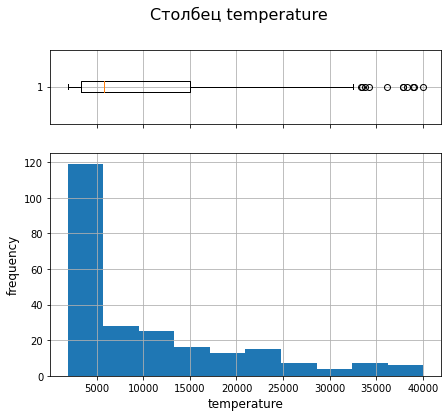

In [21]:
plot_box_hist('temperature', df_ns)

Целевой признак распределен экспоненциально.  

Медианное значение стоит чуть выше 5000 (К), в целом в данном датасете большинство наблюдений показывают температуру звезды в районе 2500-6000 Кельвинов, что является среднестатистической нормой температуры звёзд. Однако существуют значения, которые выходят за пределы усов (>32500 Кельвинов), удалять не будем, во-первых, потому что это наш целевой признак, во-вторых, подобная температура звёзд возможна: "По оценке учёных, показатели отдельных светил разные. Более холодные обладают теплом 2000-3500 К, средняя температура (у жёлтых и оранжевых) тел составляет 3500-7500 К, а горячие представители достигают значений 7500-80000 К." 

#### Относительная светимость - Luminosity(L/Lo)

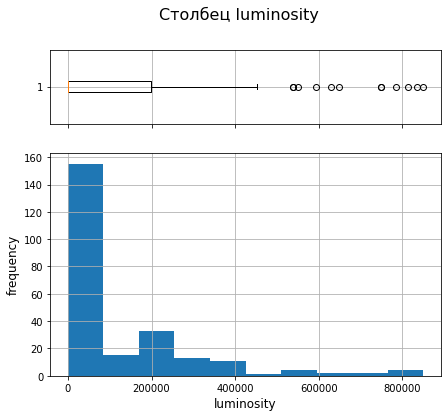

In [22]:
plot_box_hist('luminosity', df_ns)

Большинство звёзд в нашей выборке имеют очень маленькую светимость относительно Солнца (медианное значение весьма близко к нулю). Однако есть наблюдения, которые выходят за пределы и начинаются от 100.000, такое вполне уместно во вселенной, всё зависит от радиуса и температуры, а также существуют звёзды, которые в 8.100.000 раз светлее нашего Солнца

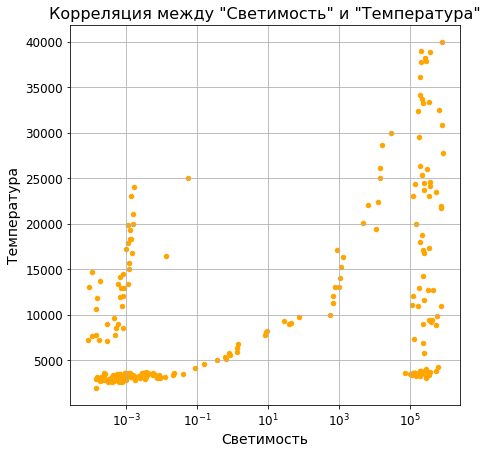

In [23]:
create_scatter_plot(
    x='luminosity',
    y='temperature',
    xname='Светимость',
    yname='Температура',
    color='orange',
    logx=True)

На графике можно заметить разделение объектов на 3 части: 1) температура находится в районе 10^(-3) и менее, а разброс светимости - от 7 500 до 25 000; 2) начинается слева снизу и идет по вогнутой парабале направо наверх; 3) Температура превышает 10^(5), а диапазон светимости - от 4000 до 40 000.

Прослеживается связь между светимостью и температурой, однако, вероятно, это зависит и от других параметров, учитывая разделение графика на 3 части.

#### Относительный радиус - Radius(R/Ro)

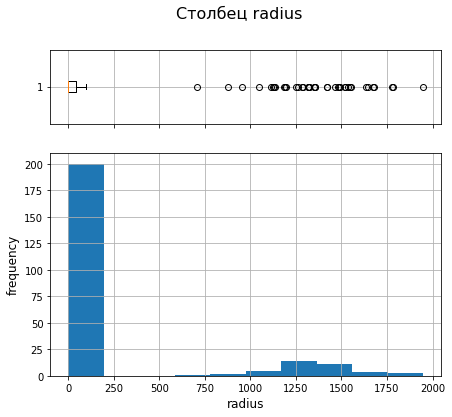

In [24]:
plot_box_hist('radius', df_ns)

Большинство наблюдений имеют меньший радиус, по сравнению с Солнцем (медианное значение в районе 0), однако существуют звёзды, которые превышают размеры Солнца в несколько тысяч раз. Для них всех характерна принадлежность к типу звезды Гигант и Сверхгигант. Поэтому мы не будем удалять подобные значения.

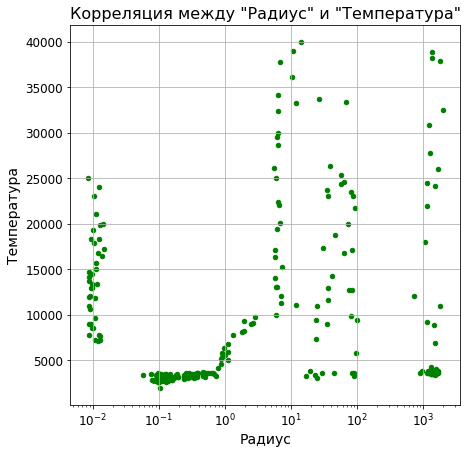

In [25]:
create_scatter_plot(
    x='radius',
    y='temperature',
    xname='Радиус',
    yname='Температура',
    color='green',
    logx=True)

Корреляция между радиусом звезды и ее температурой не столь четко прослеживается. Однако, звезды, чей радиус находится в районе от 0.1 до 1 (относительно радиуса Солнца), имеют примерно одинаковую температуру в районе около 3 500 - 4 000 Кельвинов. В остальных же случаях наблюдается сильный разброс значений.

#### Абсолютная звёздная величина - Absolute magnitude(Mv)

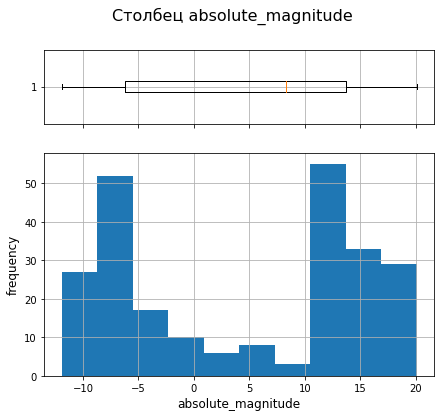

In [26]:
plot_box_hist('absolute_magnitude', df_ns)

Признак без выбросов, который имеет бимодальное распределение, практически зеркальное в отрицательной и положительной частях графика.

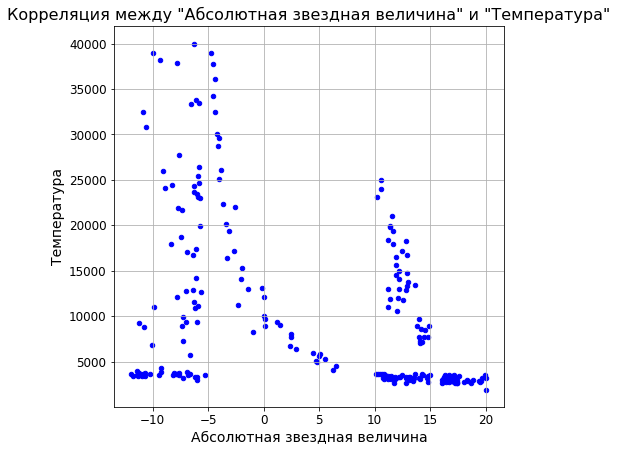

In [27]:
create_scatter_plot(
    x='absolute_magnitude',
    y='temperature',
    xname='Абсолютная звездная величина',
    yname='Температура',
    color='blue')

Заметно, что есть разброс объектов, температура которых не превышает и 5 000 Кельвинов, но абсолютная звездная величина разнится от менее чем от -10 до 20. Также виден график ветви параболы в промежутке от -5 до 10 абсолютной звездной величины.

#### Тип звезды - Star type

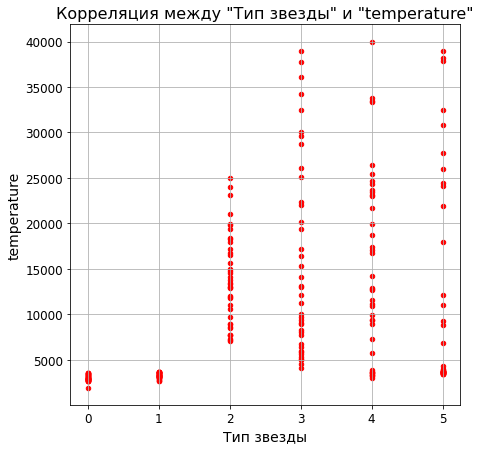

In [28]:
create_scatter_plot(
    x='star_type', 
    y='temperature',
    xname='Тип звезды',
    yname='temperature',
    color='red')

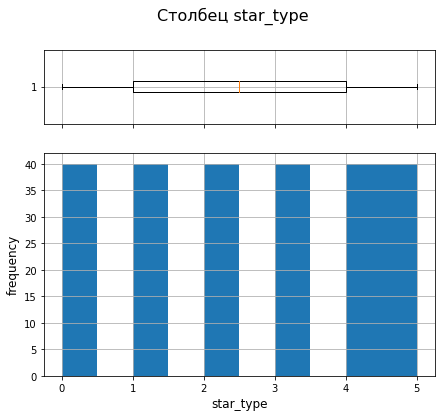

In [29]:
plot_box_hist('star_type', df_ns)

Согласно графику для типов звезд 0 и 1 температура менее 5 000 Кельвинов. Для второго типа она находится в диапазоне от 7 500 до 25 000 Кельвинов, а для остальных типов варьируется в диапазоне от менее 5 000 Кельвинов и до 40 000. Тем не менее, по крайне мере для первых трех типов звезд: "Коричневых", "Красных" и "Белых" карликов - видна корреляция между их типом и температурой.

#### Звёздный цвет - Star color

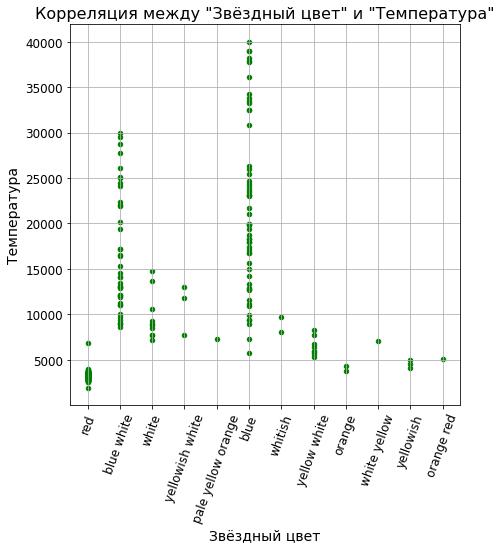

In [30]:
create_scatter_plot(
    x='star_color',
    y='temperature',
    xname='Звёздный цвет',
    yname='Температура',
    color='green',
    x_rotation=70)

In [31]:
# Количество звезд по цвету
df_ns['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
whitish                 2
orange                  2
white yellow            1
orange red              1
pale yellow orange      1
Name: star_color, dtype: int64

В значительной степени зависит температура звезды от ее цвета. Так, наименьший разброс в температурах между звездами таких цветов, как: красный, оранжево-красный, оранжевый, желтый, желто-оранжевый, желто-белый и белый. Однако, в этом плане необходимо учитывать их количество в выборке. Крайне маленькая выборка приходится на звезды бело-желтого, желтоватого, беловатого, оранжевого, оранжево-красного и желто-оранжевого цветов (не более 3). 

Ввиду этого, можно скорее проследить корреляцию между теми звездами, цвета которых больше представлены в выборке, и температура которых не сильно варьируется. К таким можно отнести: 
- Красный (112 объектов). Температура: от около 2 500 до 7 500;
- Белый (10 объектов). Температура: от около 7 500 до 15 000;
- Желто-белый (8 объектов). Температура: от 5 000 до примерно 13 000.

#### Матрица корреляции

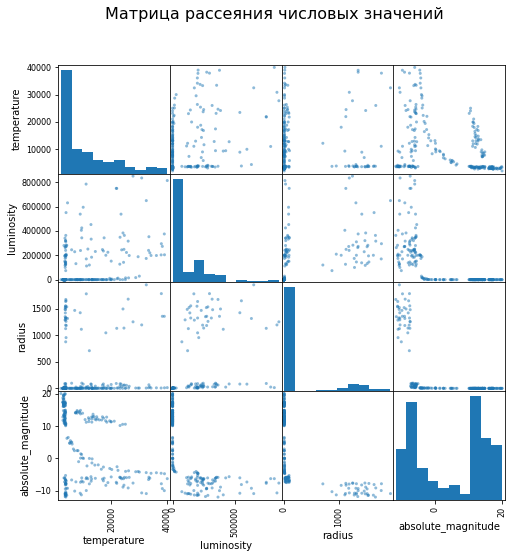

In [32]:
pd.plotting.scatter_matrix(df_ns.drop(['star_type', 'star_color'], axis=1), figsize=(8,8))

plt.suptitle('Матрица рассеяния числовых значений', fontsize=16)

plt.show()

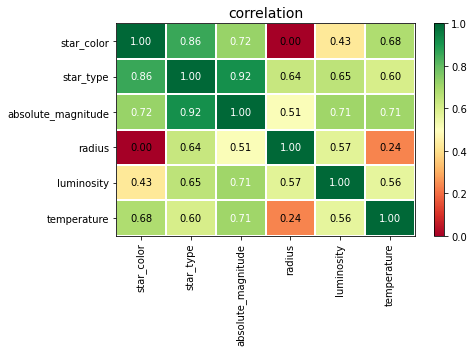

In [33]:
# список интервальных признаков
interval_features = ['temperature','luminosity','radius','absolute_magnitude']

phik_overview = df_ns.phik_matrix(interval_cols=interval_features)
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1)

Примечательно, что заметно довольно высокие корреляции между отдельными параметрами. Более того, низкая корреляция - это скорее исключение. Наибольшая корреляция наблюдается между типом звезды и ее абсолютной звездной величиной - 0.92. С целевым показателем наибольшая взаимосвязь наблюдается также с абсолютной звездной величиной и цветом звезды: 0.71 и 0.68 соответственно. С типом звезды и светимостью - 0.60 и 0.56 соответственно. Можно сделать вывод, что меньше всего температура зависит от радиуса, т. к. коэффициент корреляции составляет 0.24, однако он не равен нулю, поэтому об отсутствии полной взаимосвязи речи не идет

***Вывод:***
1. **Светимость и температура**. Наблюдается небольшая корреляция. Объекты разделены на 3 части на графике, поэтому можно заключить, что температура звезды также зависит и от других параметров;
2. **Тип звезды и температура**. Коричневые и красные карлики - < 5 000 Кельвинов, Белые карлики - от 7 500 до 25 000, иные типы - значения температур значительно варьируются;
3. **Цвет звезды и температура**. Наблюдается небольшая степень взаимозависимости. Красный цвет: от 2 500 до 7 500 Кельвинов; Белый: 7 500 - 15 000; Желто-белый: 5 000 - 13 000. Для таких цветов, как: оранжевый, желтый, оранжево-красный, желто-оранжевый количество объектов недостаточно для определения закономерности; 
4. **Радиус звезды и температура**. Не столь сильная корреляция. Примерно одинаковая температура для звезд, чей радиус находится в диапазоне от 0.1 до 1: 3 500 - 4 000 Кельвинов.
5. **Абсолютная звездная величина и температура**. Не прослеживается четкой закономерности, но видна ветвь параболы на графике в диапазоне от -5 до 10 абсолютной звездной величины;
6. **Абсолютная звездная величина и тип звезды**. Четкая корреляция, кроме красных и белых карликов - значения абсолютной звездной величины находятся в диапазоне от 10 до 15;
7. **Общая корреляция между параметрами (phik)**. Наибольший коэффициент корреляции - абсолютная звездная величина и тип звезды: 0.92. Наибольшая взаимосвязь с температурой: абсолютная звездная величина и цвет - 0.71 и 0.68 соответственно. С типом и светимостью - 0.60 и 0.56 соответственно. Радиус - 0.24.
8. Данные прошли предобработку:
     - название столбцов приведены к стандарту PEP8;
     - дубликатов и пропусков нет.
     - избавились от неявных дубликатов;
     - удалили столбец дублирующий индексацию строк.

### Подготовка данных

Исправление типов данных категориальных столбцов:

In [34]:
for col_name in ['star_type', 'star_color']:
    df_ns[col_name] = df_ns[col_name].astype('category')

In [35]:
# Проверяем:
df_ns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   temperature         240 non-null    int64   
 1   luminosity          240 non-null    float64 
 2   radius              240 non-null    float64 
 3   absolute_magnitude  240 non-null    float64 
 4   star_type           240 non-null    category
 5   star_color          240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 8.7 KB


Данные в столбцах были приведены к соответствующему им типу и понижены в разрядах для сокращения объёма занимаемой исходным набором данных памяти.

#### Разделение на выборки

In [36]:
# Выделяем признаки и целевой признак:
features = df_ns.drop('temperature', axis=1)
target = df_ns['temperature']

In [37]:
# Разбиваем данные на выборки: обучающую и тестовую - в соотношении 75/25:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

In [38]:
# Смотрим размеры выборок на кодированных данных:
for i in [features_train, features_test, target_train, target_test]:
    print(i.shape)

(180, 5)
(60, 5)
(180,)
(60,)


In [39]:
# Сохраняем названий столбцов с числовыми и категориальными признаками:
num_cols = ['luminosity', 'radius', 'absolute_magnitude']
cat_cols = ['star_type', 'star_color']

In [40]:
# Проверяем:
print('Столбцы с числовыми признаками:', *num_cols)
print('Столбцы с категориальными признаками:', *cat_cols)

Столбцы с числовыми признаками: luminosity radius absolute_magnitude
Столбцы с категориальными признаками: star_type star_color


функции определения значений категориальных признаков, различных для тестовой и тренировочной выборок:

In [41]:
def print_train_test_cat_difference(cat_cols: list, 
                                    features_train: np.array, 
                                    features_test: np.array):
    
    for col_name in cat_cols:
        cat_train = set(features_train[col_name].unique())
        cat_test = set(features_test[col_name].unique())

        if (len(cat_train) != len(cat_test) or cat_train != cat_test):
            print(f'Признак {col_name.upper()}\n')
            print('Разные распределения значений признака в тренировочной и тестовой выборках')

            if cat_train - cat_test != set():
                print('Значения только в тренировочной выборке:\n',
                      cat_train - cat_test, '\n')

            if cat_test - cat_train != set():
                print('Значения только в тестовой выборке:\n',
                      cat_test - cat_train, '\n')

            print('---\n')

Вывод значений категориальных признаков, различных для тестовой и тренировочной выборок:

In [42]:
print_train_test_cat_difference(cat_cols, features_train, features_test)

Признак STAR_COLOR

Разные распределения значений признака в тренировочной и тестовой выборках
Значения только в тренировочной выборке:
 {'white yellow', 'pale yellow orange', 'whitish'} 

Значения только в тестовой выборке:
 {'orange red'} 

---



In [43]:
features_train['star_color'].value_counts()

red                   84
blue                  40
blue white            32
white                  9
yellow white           6
whitish                2
yellowish              2
yellowish white        2
orange                 1
pale yellow orange     1
white yellow           1
orange red             0
Name: star_color, dtype: int64

In [44]:
features_test['star_color'].value_counts()

red                   28
blue                  16
blue white             9
yellow white           2
orange                 1
orange red             1
white                  1
yellowish              1
yellowish white        1
pale yellow orange     0
white yellow           0
whitish                0
Name: star_color, dtype: int64

* В тренировочной и тестовой выборках в столбцах признаков нет полного соответствия значений - кодирование данных необходимо произвести с помощью техники One-Hot Encoding. 
    

* Значения в столбце `luminosity` отличаются большим диапазоном - данные необходимо масштабировать.
    

* Кодирование и масштабирование значений тестовой выборки должны происходить на объектах кодирования и масштабирования, обученных на тренировочной выборке.

#### Кодирование данных

In [45]:
# Сохраняем копии тренировочной и тестовой выборок:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

target_train_ohe = target_train.copy()
target_test_ohe = target_test.copy()

In [46]:
# Кодируем признаки через OHE:

encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Обучем:
encoder_ohe.fit(features_train_ohe[cat_cols])

# Трансформируем:
features_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_ohe[cat_cols])
features_test_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_ohe[cat_cols])

# Удаляем исходных незакодированных столбцов:
features_train_ohe = features_train_ohe.drop(cat_cols, axis=1)
features_test_ohe = features_test_ohe.drop(cat_cols, axis=1)

In [47]:
# Масштабирование:

scaler = StandardScaler()

scaler.fit(features_train_ohe[num_cols])

features_train_ohe[num_cols] = scaler.transform(features_train_ohe[num_cols])
features_test_ohe[num_cols] = scaler.transform(features_test_ohe[num_cols])

In [48]:
# Смотрим размеры выборок на кодированных данных OHE:
for i in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(i.shape)

(180, 20)
(60, 20)
(180,)
(60,)


In [49]:
# Выведем 5 случайных строк:
features_train_ohe.sample(5)

,luminosity,radius,absolute_magnitude,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x1_blue,x1_blue white,x1_orange,x1_pale yellow orange,x1_red,x1_white,x1_white yellow,x1_whitish,x1_yellow white,x1_yellowish,x1_yellowish white
159,0.587515,-0.427660,-0.867900,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,-0.594615,-0.441365,0.927503,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,-0.594615,-0.441214,1.299790,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
135,-0.594615,-0.439924,0.980140,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88,-0.594615,-0.441367,0.809787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Преобразование признаков и целевого признака тренировочной и тестовой выборок в тензоры:

In [50]:
x_train_torch = torch.FloatTensor(features_train_ohe.values)
x_test_torch = torch.FloatTensor(features_test_ohe.values)

y_train_torch = torch.FloatTensor(target_train.values)
y_test_torch = torch.FloatTensor(target_test.values)

***Вывод:***   
Данные закодированы и масштабированы, а также переведены в тензоры.

## Построение базовой нейронной сети

---

**Функции активации** - добавляют нелинейность в нейросеть.

* `nn.Sigmoid()` - логистическая функция активации.

>Применяется в моделях, предсказывающих вероятность от `0` до `1` на выходе.
>
>Может приводить к "взрыву градиентов" (слишком большим градиентам).

$$ Sigmoid(x) = \frac {1}{1 + e^{-x}} $$

* `nn.Tanh()` - гиперболический тангенс

$$ Tanh(x) = \frac {e^x - e ^{-x}}{e^x + e^{-x}} $$

>Используется в скрытых слоях при небольшом их количестве.

* `nn.ReLU()` - параметрическая выпрямительная функция.

$$ ReLU(x) = max(0, x) $$

>При отрицательных значениях признаков принимает значение `0`, что может снижать качество обучения.

* `nn.LeakyReLU()` - частный случай `nn.ReLu()`.

$$ LeakyReLU(x) = max(0.1 x, x) $$

* `nn.ELU()` - экспоненциальная линейная функция (разновидность `nn.ReLu()`).

$$ ELU(x) = \begin{cases}
k (e^x - 1),&x<0 \\
x,&x>=0
\end{cases} $$

* `nn.SiLU()` - саморегулируемая функция активации.

$$ SiLU(x) = x Sigmoid(x) = \frac {x}{1 + e^{-x}} $$

---

**Функции потерь** - помогают найти наилучшее значение параметров на тренировочных данных.

Функции потерь для **одного** объекта:

* `nn.MSELoss` - среднеквадратичное отклонение.

$$ MSE(y, \hat y) = (y - \hat y)^2 $$

* `nn.L1Loss` - среднее абсолютное отклонение.

$$ MAE(y, \hat y) = |y - \hat y| $$  

Вычисление функции потерь для **набора данных**:

* Подсчёт среднего арифметического функции потерь для всех объектов набора данных.
* Вычисление суммы значений функции потерь для всех наборов данных.

---

**Оптимизатор** - содержит параметры, которые необходимо оптимизировать, реализацию алгоритма численной минимизации и необходимые гиперпараметры алгоритма.

* `optim.SGD` - метод стохастического градиентного спуска.

>Качество обучения зависит от величины шага.

$$ w_i = w_i - \eta \nabla L_i  $$

* `optim.RMSprop` - метод корневого среднеквадратического распространения (улучшение `optim.SGD()`).

$$ v_i = \gamma v_{i-1} + (1 - \gamma) (\nabla L_i)^2 $$

$$ w_i = w_{i-1} - \frac {\eta}{\sqrt {v_i}} \nabla L_i $$

* `optim.Adam` - метод адаптивной оценки моментов (улучшение `optim.SGD()`).

>Обладает быстрой сходимостью к локальному минимуму.

$$ m_i = \beta_1 m_{i-1} + (1 - \beta_1) \nabla L_i $$
$$ v_i = \beta_2 v_{i-1} + (1 - \beta_2) (\nabla L)^2 $$
$$ \hat m_i = \frac {m_i}{1 - \beta_1^i} $$
$$ \hat v_i = \frac {v_i}{1 - \beta_2^i} $$
$$ w_i = w_{i-1} - \frac {\alpha \hat m_i}{\sqrt {\hat v_i} + \epsilon} $$

* $ \nabla L $ - градиент функции потерь
* $ \eta $ - скорость обучения
* $ \gamma $ - параметр забывания
* $ \alpha = 0.0001 $
* $ \beta_1 = 0.9 $
* $ \beta_2 = 0.999 $

---

**Инициализация весов** - влияет на скорость нахождения функцией её минимума.

* `init.uniform_()`, `init.normal_()` - инициализация равномерным и нормальным распределением.

* `init.xavier_uniform_()` / `init.xavier_normal_()` - инициализация Ксавье (симметричная функция активации относительно `0`).

* `init.kaiming_uniform_()` / `init.kaiming_normal_()` - инициализация Кайминга (несимметричная функция активации относительно `0`).

---

**Регуляризация весов** - подход, при котором модель штрафуется за большие значения весов.

* `nn.BatchNorm1d()` - метод регуляризации и стабилизации обучения.

>Борется со "взрывом градиента".
>
>Улучшает сходимость обучения.
>
>Уменьшает зависимость от гиперпараметров и влияние инициализации весов.

$$ y_i = \gamma \hat X + \beta $$

* $ \hat X $ - нормализованные признаки
* $ \gamma $ - масштаб
* $ \beta $ - сдвиг


* `nn.Dropout()` - "выключение" части нейронов из сети.

>Применяется при переобучении.
>
>Не применяется вместе с `nn.BatchNorm1d()`.
>
>Требует больше эпох обучения для сходимости.

---

### Базовая нейронноя сеть 1

#### Нейронная сеть 1

Сеть состоит из входных нейронов, 2-х скрытых слоев и выходного слоя:

In [51]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        
        out = self.fc3(out)
        
        return out

Зададим количество нейронов на каждом слое сети:

In [52]:

in_neurons = x_train_torch.shape[1]
hidden_neurons_1 = 256
hidden_neurons_2 = 64
out_neurons = 1                               # скрытых слоев будем находить перебором от 300 до 1000

loss = nn.MSELoss()                           # задаем функцию потерь

num_epochs = 10000                             # число комбинаций для перебора

Создадим функцию для обучения нейронной сети и вывода RMSE_test:

In [53]:
def net_learn(num_epochs, net):
    rmse_best = 50000
    rmse_list = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
 
        preds = net.forward(x_train_torch).flatten()
            
        loss_value = loss(preds, y_train_torch)

        loss_value.backward()
            
        optimizer.step()
    
      #  if epoch % 150 ==0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(x_test_torch)
        rmse = mean_squared_error(y_test_torch.detach().numpy(), test_preds.detach().numpy(), squared=False)
        rmse_list.append(rmse)
        if rmse < rmse_best:
            rmse_best = rmse
            test_preds_best = test_preds 
            best_epoch = epoch 
    print('RMSE_test:', round(rmse_best, 3), '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
    return test_preds_best, rmse_list

In [54]:
net = Net(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
test_preds, rmse_list = net_learn(num_epochs, net)

RMSE_test: 4122.821 | ep 9999 from 10000 | best_epoch: 2503


- Значение RMSE ниже 4500 достигнуто базовой моделью

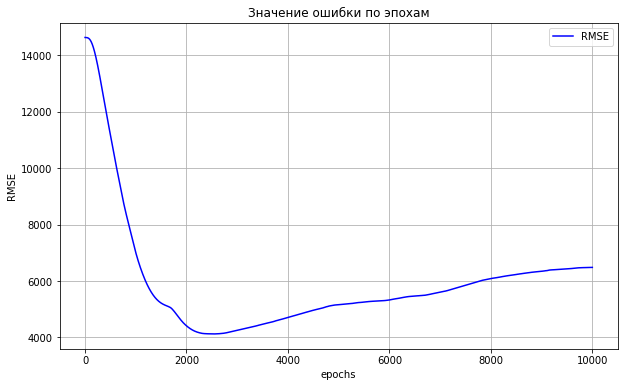

In [55]:
# График значения ошибки по эпохам
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=[10,6])
sns.lineplot(x=epochs, y=rmse_list, label='RMSE', color='blue')
plt.legend()
plt.title('Значение ошибки по эпохам')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.grid()
plt.show()

- Оптимальное кол-во эпох в районе- 2500, далее - оверфит.

#### График "Факт — Прогноз"

In [56]:
test_preds = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])  # преобразуем данные
target_test = pd.DataFrame((target_test), columns=['temperature']).reset_index().drop('index', axis=1)

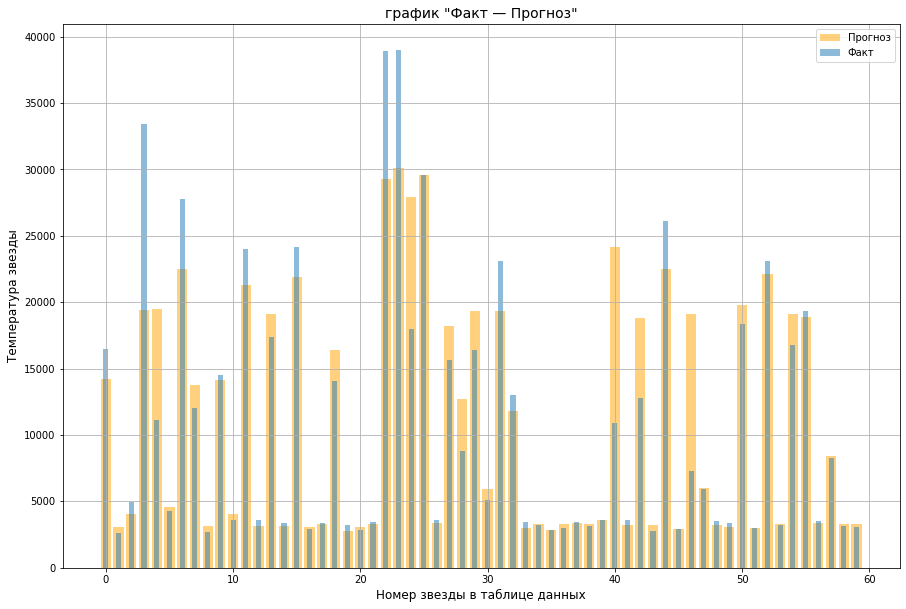

In [57]:
fig, ax = plt.subplots(figsize=[15,10])
plt.bar(x=test_preds.index, height=test_preds['temperature'], color='orange', alpha=0.5, label='Прогноз')
plt.bar(x=target_test.index, height=target_test['temperature'], width= 0.4, alpha=0.5, label='Факт')
plt.title('график "Факт — Прогноз"', fontsize=14)
plt.xlabel('Номер звезды в таблице данных', fontsize=12)
plt.ylabel('Температура звезды', fontsize=12)
ax.legend()
plt.grid()
plt.show()

- Прогнозы более точны на малых значениях температуры до 5000 К, что связано с пребладанием в исходных данных малых значений температуры, радиуса и светимостей.

### Улучшение нейронной сети 1

Посмотрим на работу сети при обучении батчами, для этого дополним функцию net_learn так, чтобы использовать батчи.  


Оьбъявим функцию EarlyStopping, который будет предоствращать переобучение и останавливать цикл обучения по достижению оптимального значения:

In [58]:
class EarlyStopping():
    def __init__(self, patience=7, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss

            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
             self.counter += 1
                
             if self.counter >= self.patience:
                print('Early stopping')
                self.early_stop = True

Функция net_learn с разбиением на батчи и early stopping:

In [59]:
def net_learn_batches(num_epochs, net):
    early_stopping = EarlyStopping() 
    rmse_best = 50000
    for epoch in range(num_epochs):
        net.train()
        for batch in train_dataloader:
            data_train, temperature_train = batch  
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temperature_train))
            loss_value.backward()
            optimizer.step()

        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch
  
                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        rmse = mean_squared_error(target_test, predicted_temp, squared=False)
        rmse_list.append(rmse)
        if rmse < rmse_best:
            rmse_best = rmse
            best_epoch = epoch
            test_preds_best = predicted_temp
        early_stopping(rmse)

        if early_stopping.early_stop:
            break 
    print('RMSE:', round(rmse_best, 3), '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
    return test_preds_best

In [60]:
class Net_Batch(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net_Batch, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)

        self.act1 = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
        self.act2 = nn.ReLU()
        
        
        self.fc3 = nn.Linear(hidden_size2, num_classes) 
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.bn1(out)
       
        out = self.fc2(out)
        out = self.act2(out)
        
        out = self.fc3(out)
        
        return out

Ищем оптимальный размер батча с помощью перебора по списку:

In [61]:
batch_size = list(range(15, len(x_train_torch), 25))

dataset_train = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
dataset_test = torch.utils.data.TensorDataset(x_test_torch, y_test_torch)

In [62]:
for b in batch_size:
    train_dataloader = DataLoader(dataset_train, batch_size=b, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(dataset_test, batch_size=b, num_workers=0)  
    print('batch_size:', b)    
    net = Net_Batch(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    batch_test_preds = net_learn_batches(num_epochs, net)
    print('---------------------------')

batch_size: 15
Early stopping
RMSE: 4461.171 | ep 65 from 10000 | best_epoch: 58
---------------------------
batch_size: 40
Early stopping
RMSE: 4374.133 | ep 144 from 10000 | best_epoch: 137
---------------------------
batch_size: 65
Early stopping
RMSE: 5754.179 | ep 231 from 10000 | best_epoch: 224
---------------------------
batch_size: 90
Early stopping
RMSE: 5983.215 | ep 306 from 10000 | best_epoch: 299
---------------------------
batch_size: 115
Early stopping
RMSE: 5378.607 | ep 325 from 10000 | best_epoch: 318
---------------------------
batch_size: 140
Early stopping
RMSE: 6236.807 | ep 249 from 10000 | best_epoch: 242
---------------------------
batch_size: 165
Early stopping
RMSE: 11140.362 | ep 154 from 10000 | best_epoch: 147
---------------------------


Лучший размер батча 40, однако, обучение батчами не улучшает значение RMSE, и более того, показывает себя хуже и обучается дольше.

Поэтому далее будем использовать исходную функцию net_learn.

Инициализируем сеть с разными вариантами параметра в dropout, увеличив кол-во эпох: 

In [63]:
dropout = [0.5, 0.7, 0.8, 0.9] 
comb = 10
num_epochs = 5000

In [64]:
for c in range(comb):
    p1 = random.choice(dropout)
    p2 = random.choice(dropout)
    print('drop =', p1, p2)
    class Net_Dropout(nn.Module):
        def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
            super(Net_Dropout, self).__init__()
        
            self.fc1 = nn.Linear(input_size, hidden_size1)
            self.act1 = nn.Tanh()
            self.dp1 = nn.Dropout(p=p1)
        
            self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
            self.act2 = nn.ReLU()
            self.dp2 = nn.Dropout(p=p2)
        
            self.fc3 = nn.Linear(hidden_size2, num_classes) 
        
        
        def forward(self, x):
            
            out = self.fc1(x)
            out = self.act1(out)
            out = self.dp1(out)
        
            out = self.fc2(out)
            out = self.act2(out)
            out = self.dp2(out)
            
            out = self.fc3(out)
            return out
           
    net = Net_Dropout(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
    drop_test_preds = net_learn(num_epochs, net)
    
    print('---------------------------')  

drop = 0.9 0.7
RMSE_test: 4060.2 | ep 4999 from 5000 | best_epoch: 2418
---------------------------
drop = 0.5 0.8
RMSE_test: 4096.067 | ep 4999 from 5000 | best_epoch: 2461
---------------------------
drop = 0.8 0.7
RMSE_test: 4115.02 | ep 4999 from 5000 | best_epoch: 2509
---------------------------
drop = 0.7 0.8
RMSE_test: 4064.923 | ep 4999 from 5000 | best_epoch: 2486
---------------------------
drop = 0.9 0.8
RMSE_test: 4044.734 | ep 4999 from 5000 | best_epoch: 2289
---------------------------
drop = 0.7 0.8
RMSE_test: 4077.324 | ep 4999 from 5000 | best_epoch: 2458
---------------------------
drop = 0.7 0.7
RMSE_test: 4045.987 | ep 4999 from 5000 | best_epoch: 2415
---------------------------
drop = 0.8 0.9
RMSE_test: 4099.693 | ep 4999 from 5000 | best_epoch: 2390
---------------------------
drop = 0.9 0.5
RMSE_test: 4075.032 | ep 4999 from 5000 | best_epoch: 2535
---------------------------
drop = 0.5 0.8
RMSE_test: 4101.32 | ep 4999 from 5000 | best_epoch: 2397
------------

- Результаты чуть улучшились относительно базовой модели. 

In [65]:
drop_test_preds = pd.DataFrame(drop_test_preds[0].detach().numpy(), columns=['temperature'])

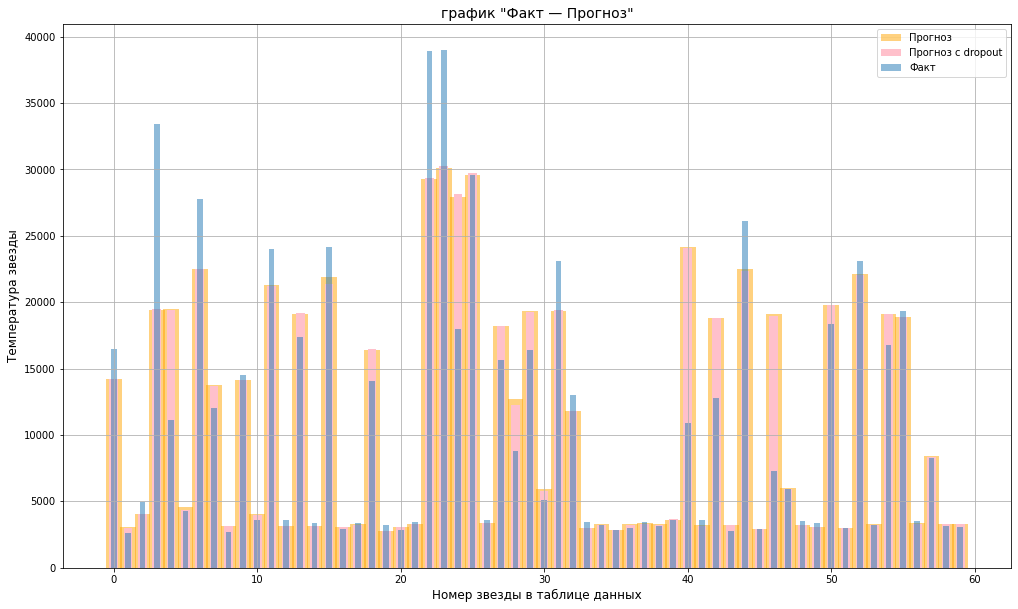

In [66]:
fig, ax = plt.subplots(figsize=[17,10])
plt.bar(x=test_preds.index, height=test_preds['temperature'], color='orange' , label='Прогноз', width= 1.1, alpha=0.5)
plt.bar(x=drop_test_preds.index, height=drop_test_preds['temperature'], color='pink' , label='Прогноз c dropout', width= 0.6)
plt.bar(x=target_test.index, height=target_test['temperature'], width= 0.4, alpha=0.5, label='Факт')
plt.title('график "Факт — Прогноз"', fontsize=14)
plt.xlabel('Номер звезды в таблице данных', fontsize=12)
plt.ylabel('Температура звезды', fontsize=12)
ax.legend()
plt.grid()
plt.show()

#### ***Вывод:***  

- Обе модели показывают практически одинаковые результаты, причем прогнозы более точны на малых значениях температуры до 5000 К, что связано с пребладанием в исходных данных малых значений температуры, радиуса и светимостей.  


- На таком малом обьеме данных нецелесообразно использовать обучение сети с помощью батчей, а так же проводить регуляризацию - обе модели показывают примерно одинаковые значения RMSE ~ 4100, что укладывается в заданную границу 4500.

## Построение базовой нейронной сети 2

Для чистоты эксперемента возьмем изначальный датасет и проведем небходимую предобработку данных

In [67]:
RANDOM_STATE = RS = 88

In [68]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [69]:
def passthrough(x):
    return x

def scatterplot_feature_target(df: pd.DataFrame, feature: str, target: str,
                               func_x=passthrough, func_y=passthrough,
                               prefix_x='', prefix_y='', size=(15,5)
                              ):
    '''
    Выводит точечный график зависимости двух переменных.
    Может предварительно применять функции к переменным.
    df: датафрейм
    feature: название признака по оси X
    target: название признака по оси Y
    func_x: функция, которая будет применена к feature
    func_y: функция, которая будет применена к target
    prefix_x: префикс, который будет добавлен к подписи оси X
    prefix_y: префикс, который будет добавлен к подписи оси Y
    size: размер графика в дюймах
    '''

    df = df.copy()
    df[feature] = func_x(df[feature])
    df[target] = func_y(df[target])
    
    fig, ax = plt.subplots(figsize=size, dpi=150)
    sns.scatterplot(data=df, x=feature, y=target)
    
    ax.set_xlabel(f'{prefix_x}{feature}')
    ax.set_ylabel(f'{prefix_y}{target}')
    ax.set_title(f'{prefix_y}{target} ~ {prefix_x}{feature}');

In [70]:
# defaults for charts

# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor':'0.98', 'grid.color':'0.9', 'axes.edgecolor':'1.0', 'figure.figsize':(15, 5)})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=16,
       titlepad=10,
      )

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [71]:
data = pd.read_csv('/datasets/6_class.csv')

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [73]:
data = data.rename(columns={
    'Temperature (K)':'temperature',
    'Luminosity(L/Lo)':'luminosity',
    'Radius(R/Ro)':'radius',
    'Absolute magnitude(Mv)':'absolute_magnitude',
    'Star type':'star_type',
    'Star color':'star_color'})

In [74]:
data = data.drop('Unnamed: 0', axis=1)

In [75]:
# Переводим в PEP8:
cat_columns = data.select_dtypes(exclude='number').columns.to_list()

data[cat_columns] = data[cat_columns].apply(lambda x: x.str.lower())
data[cat_columns] = data[cat_columns].apply(lambda x: x.str.strip(' '))
data.star_color = data.star_color.str.replace('-', ' ')

In [76]:
data.sample(5)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
76,2890,0.003,0.240,13.460,1,red
145,8924,0.000,0.009,14.870,2,blue white
102,23000,127000.000,36.000,-5.760,4,blue
93,4980,0.357,1.130,4.780,3,yellowish
64,2935,0.000,0.116,18.890,0,red


### Star color

In [77]:
data['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
whitish                 2
orange                  2
white yellow            1
orange red              1
pale yellow orange      1
Name: star_color, dtype: int64

- Спектральный класс определяется цветом звезды. Диапазон температур на поверхности звезды связан с ее спектральным классом.
>
- Таблица с диапазонами температур, соответствующих спектральному классу. В данных есть звезды, цвет которых вне стандартной классификации, для которых подоберем наиболее близкий класс из таблицы.
  
| Color              | Spectral class |  Temperature, K |
|:-------------------|:--------------:|----------------:|
| blue               |        O       | 30 000 - 60 000 |
| blue white         |        B       | 10 000 - 30 000 |
| white              |        A       |  7 500 - 10 000 |
| yellow white       |        F       |   6 000 - 7 500 |
| yellow             |        G       |   5 000 - 6 000 |
| orange             |        K       |   3 500 - 5 000 |
| red                |        M       |   2 000 - 3 500 |

- Признак `Star color` — категориальный, но может быть заменен числовым. Для обучения модели используем среднюю температуру, соответствующую спектральному классу звезды.  
- Поскольку температура изменяется нелинейно, вместо средней температуры диапазона лучше взять среднее значение логарифма диапазона температур.

#### Корректировка значений вне классификации

In [78]:
# неявный дубликат
data.star_color = data.star_color.replace('white yellow', 'yellow white')

# неизвестная классификация.. по характеристикам соответствует 'yellow white'
data.star_color = data.star_color.replace('pale yellow orange', 'yellow white')

# неизвестная классификация.. по характеристикам соответствует 'white'
data.star_color = data.star_color.replace('yellowish white', 'white')

# неизвестная классификация.. по характеристикам соответствует 'white'
data.star_color = data.star_color.replace('whitish', 'white')

# неизвестная классификация.. по характеристикам соответствует 'orange'
data.star_color = data.star_color.replace('yellowish', 'orange')

# неизвестная классификация.. по характеристикам соответствует 'orange'
data.star_color = data.star_color.replace('orange red', 'orange')

Нестандартные спектральные классы заменены на стандартные.

In [79]:
data['star_color'].value_counts()

red             112
blue             56
blue white       41
white            15
yellow white     10
orange            6
Name: star_color, dtype: int64

#### Сопоставление цвета и диапазона температур

In [80]:
color_temperature = {'blue': [30000, 60000],
                     'blue white': [10000, 30000],
                     'white': [7500, 10000],
                     'yellow white': [6000, 7500],
                     'orange': [3500, 5000],
                     'red': [2000, 3500],
                    }

In [81]:
data[['Temp_min','Temp_max']] = pd.DataFrame(data.star_color.apply(lambda x: color_temperature[x]).tolist())

data['temp_log_avg'] = (np.log(data.Temp_min) + np.log(data.Temp_max)) / 2

data = data.drop(['Temp_min','Temp_max'], axis=1)

In [82]:
data.sample(10)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,temp_log_avg
87,10980,0.001,0.009,11.190,2,blue white,9.760
67,2817,0.001,0.091,16.450,0,red,7.881
154,25070,14500.000,5.920,-3.980,3,blue white,9.760
216,9320,29.000,1.910,1.236,3,blue white,9.760
141,21020,0.002,0.011,11.520,2,blue,10.656
120,3323,0.000,0.091,17.160,0,red,7.881
31,30000,28840.000,6.300,-4.200,3,blue white,9.760
40,3826,200000.000,19.000,-6.930,4,red,7.881
195,3598,0.003,0.670,13.667,1,red,7.881
237,8829,537493.000,1423.000,-10.730,5,white,9.066


- Для каждого спектрального класса рассчитано среднее значение логарифма диапазона температур.  
- Это позволит заменить категориальное обозначение спектрального класса на числовое.  
- Возможно такой подход повысит качество модели.

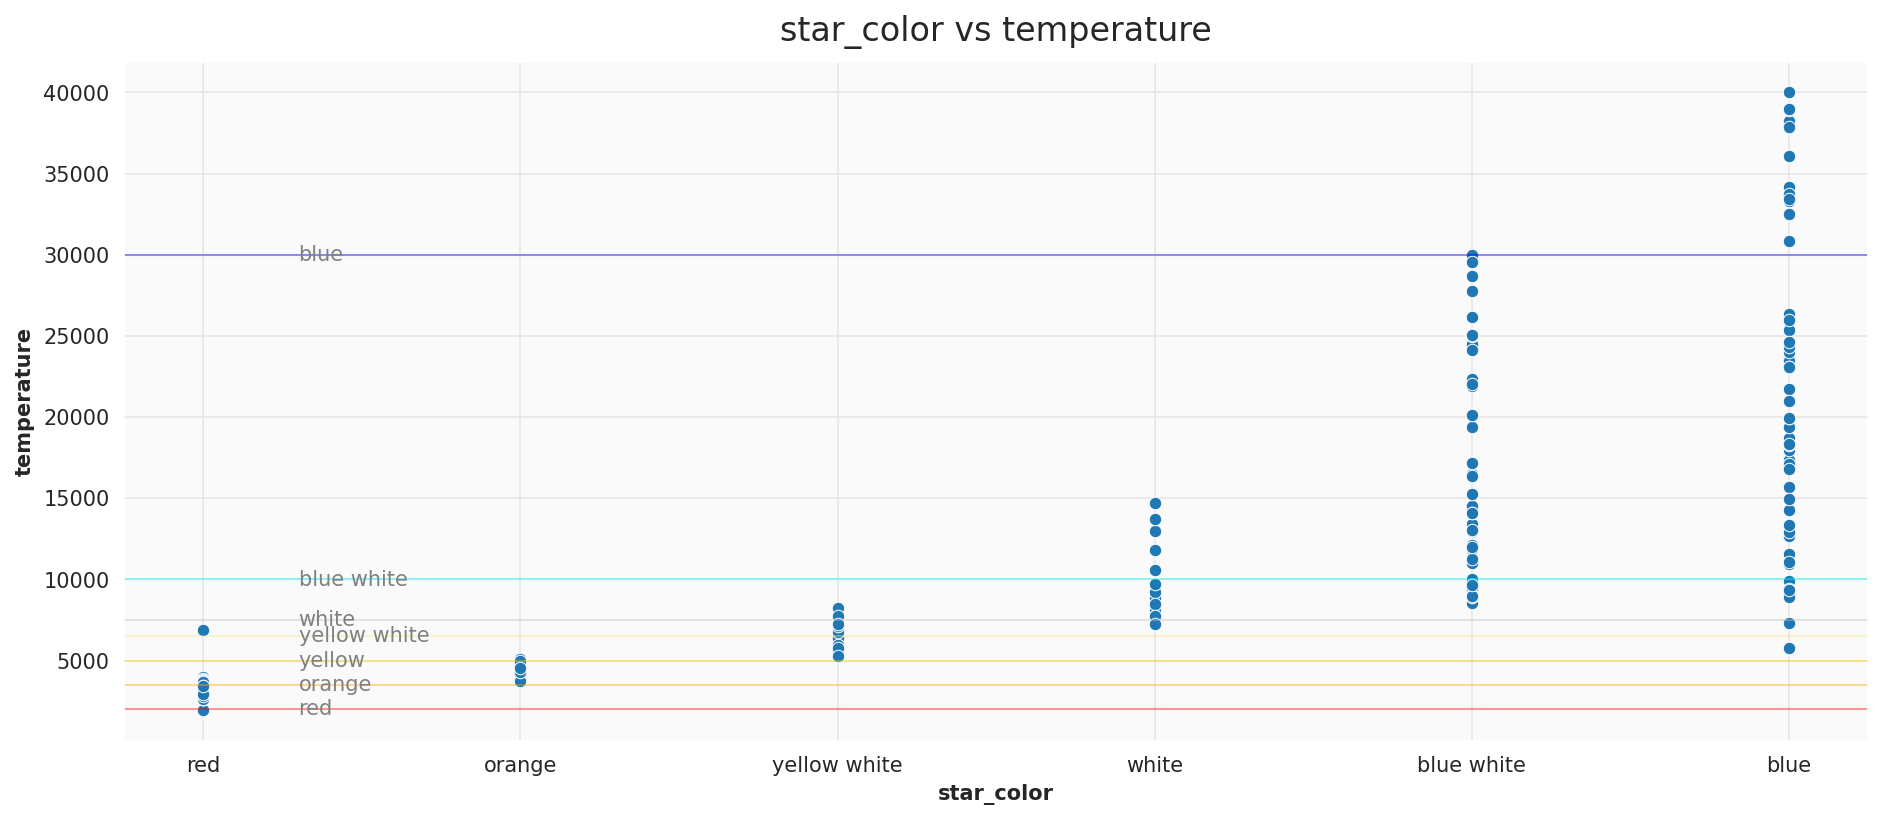

In [83]:
# Посмотрим на распределение:
fig, ax = plt.subplots(figsize=(15,6), dpi=150)

sns.scatterplot(data=data.sort_values('temp_log_avg'), x='star_color', y='temperature')
ax.set_title('star_color vs temperature')

levels_dict = {30000: ('blue', 'blue'),
               10000: ('cyan', 'blue white'),
                7500: ('silver', 'white'),
                6500: ('khaki', 'yellow white'),
                5000: ('gold', 'yellow'),
                3500: ('orange', 'orange'),
                2000: ('red', 'red'),
              }

for level, (color, label) in levels_dict.items():
    ax.axhline(level, color=color, linewidth=1, linestyle='-', alpha=0.4)
    ax.text(0.3, level, label, ha='left', va='center', color='gray')

plt.show()

   - Линия с названием спектрального класса соответствует минимальной температуре для этого класса в соответствии с таблицей спектральных классов.

   - Больше всего несоответствий между классификационной таблицей и входными данными в классе `blue` — температура большинства звезд соотвествует классу `blue white`, а температура некоторых звезд соответствуют классу `yellow`. Другие классы также не дают точного соответствия.

### Luminosity:

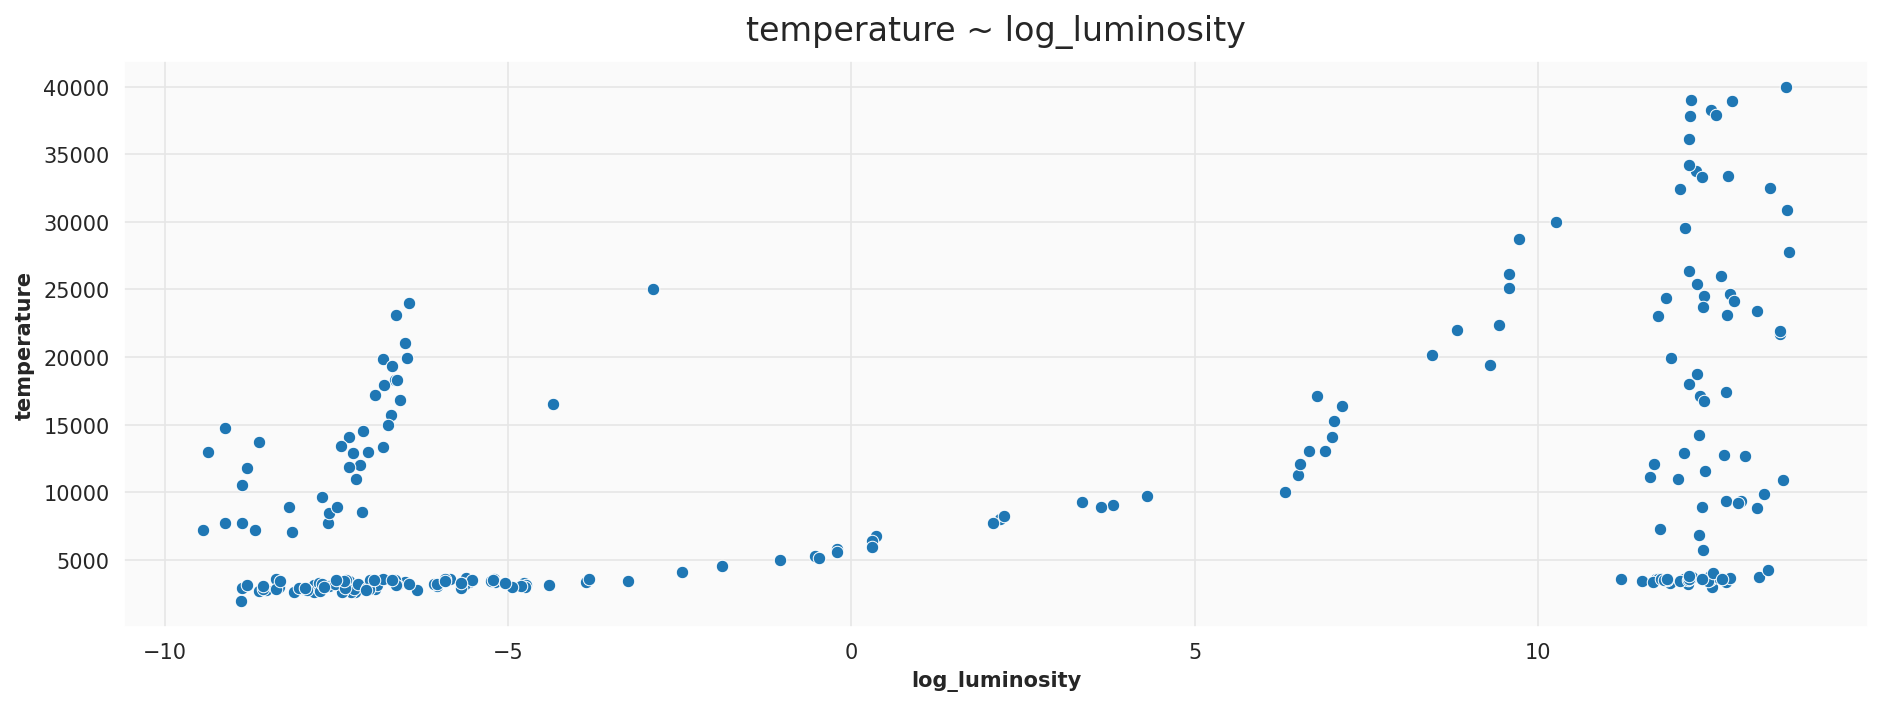

In [84]:
scatterplot_feature_target(data, 'luminosity', 'temperature', func_x=np.log, prefix_x='log_')

- Для логарифма `luminosity` лучше детализируется область x=0 и на графике прослеживаются определенные зависимости.

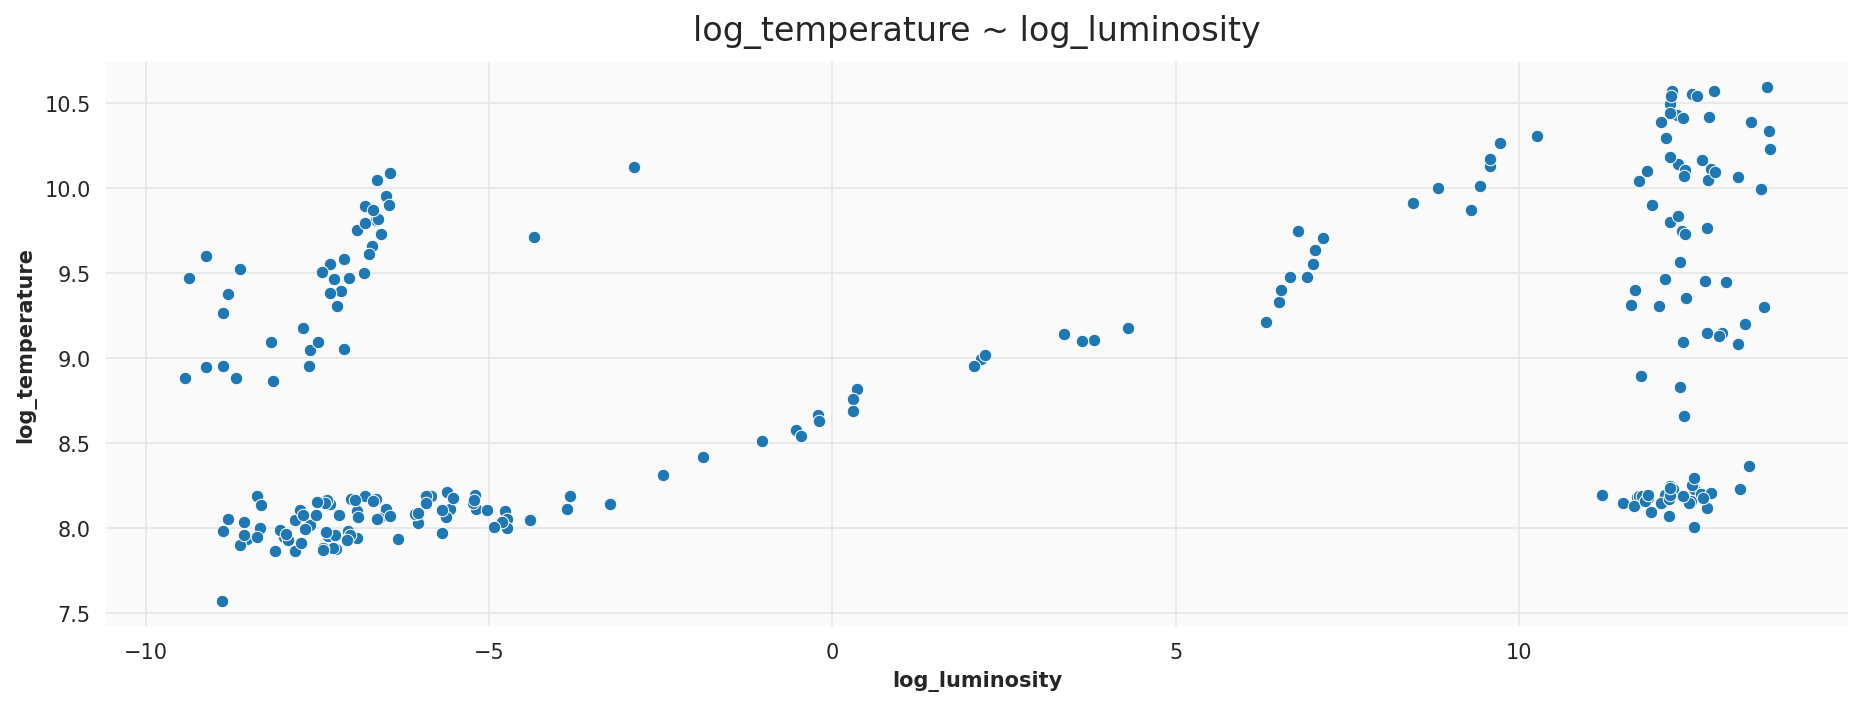

In [85]:
scatterplot_feature_target(data, 'luminosity', 'temperature', func_x=np.log, func_y=np.log, prefix_x='log_', prefix_y='log_')

- Дополнительно прологарифмирован признак `temperature` — зависимости сохранились, а в области низких температур детали стали более различимы. На последующих графиках имеет смысл сразу логарифмировать оси, вдоль которых величина изменяется нелинейно.

- На графике зависимости `temperature` от `luminosity` (точнее, их логарифмов) выделяются несколько характерных кластеров. 

### Radius:

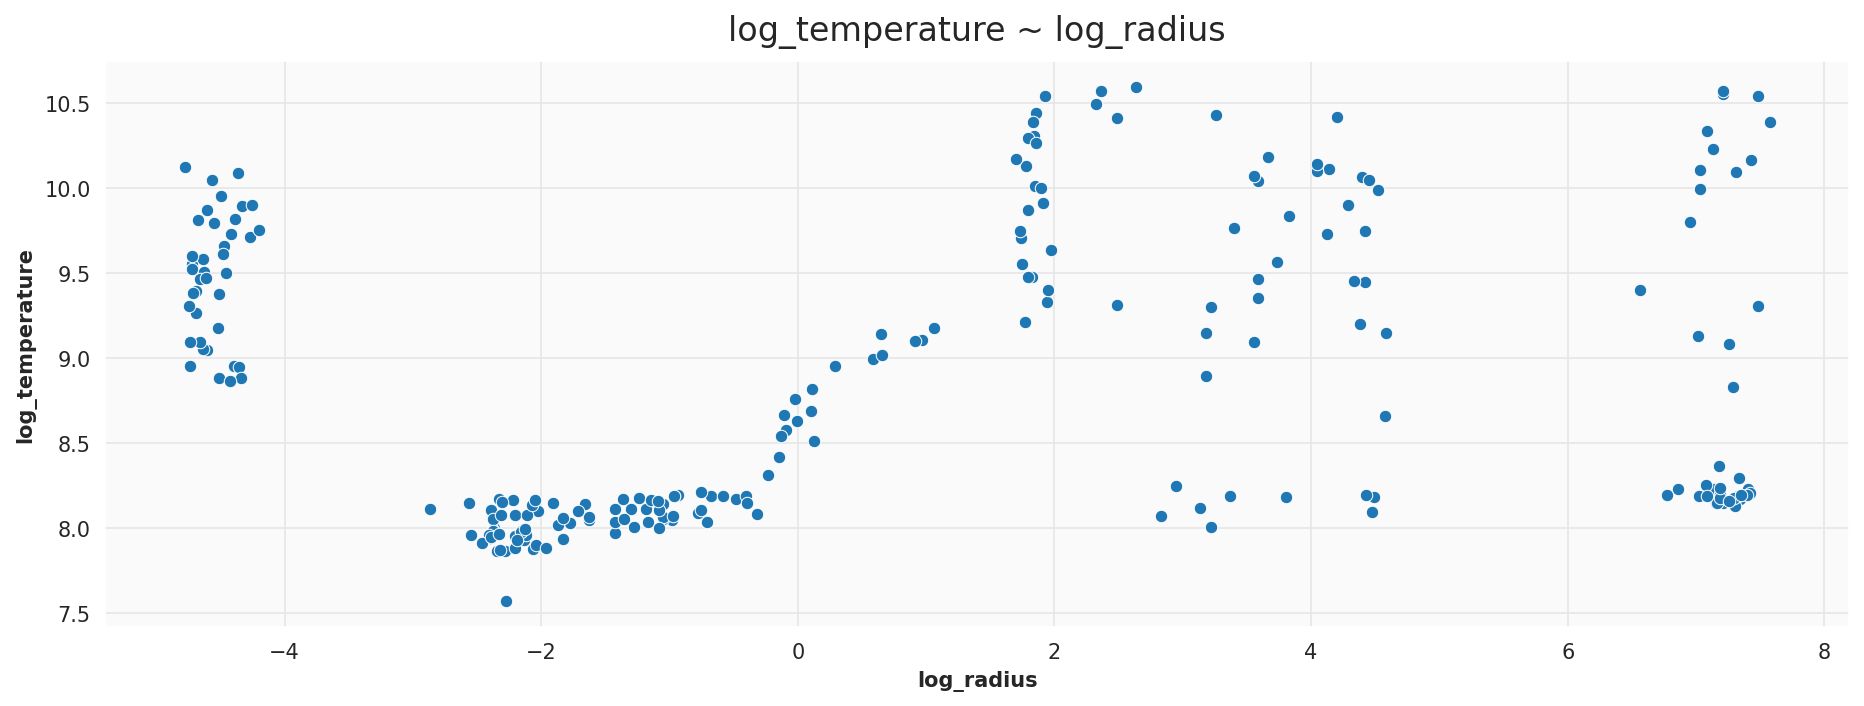

In [86]:
scatterplot_feature_target(data, 'radius', 'temperature', func_x=np.log, func_y=np.log, prefix_x='log_', prefix_y='log_')

- На графике зависимости `log_temperature ~ log_radius` выделяются несколько характерных кластеров. Некоторые их них хорошо обособлены.

### Absolute Magnitude:

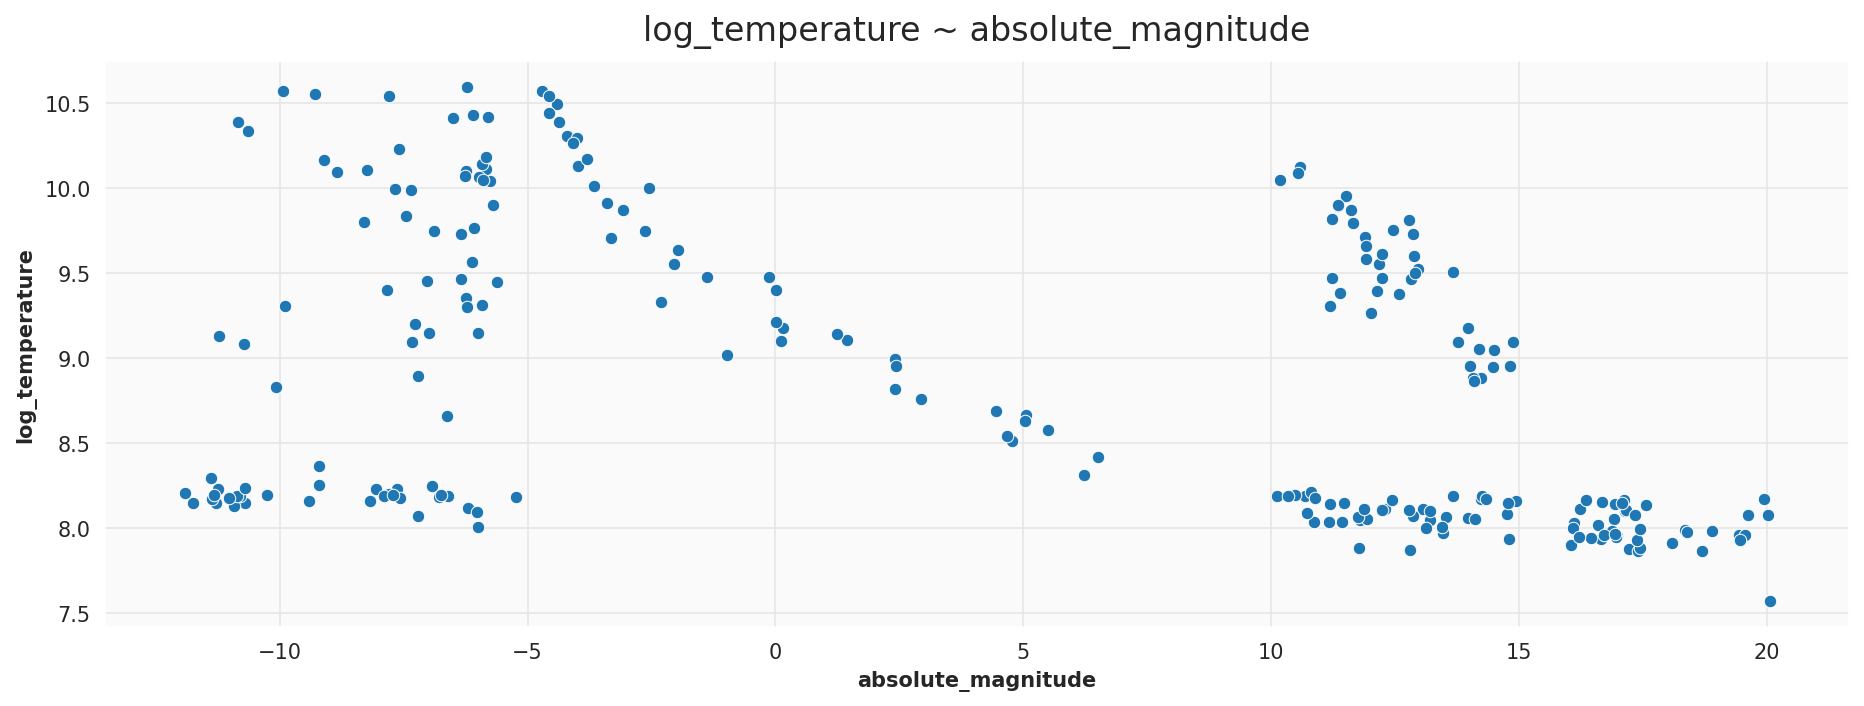

In [87]:
scatterplot_feature_target(data, 'absolute_magnitude', 'temperature', func_y=np.log, prefix_y='log_')

- На графике log_temperature ~ absolute_magnitude видны несколько кластеров.

### Star type:

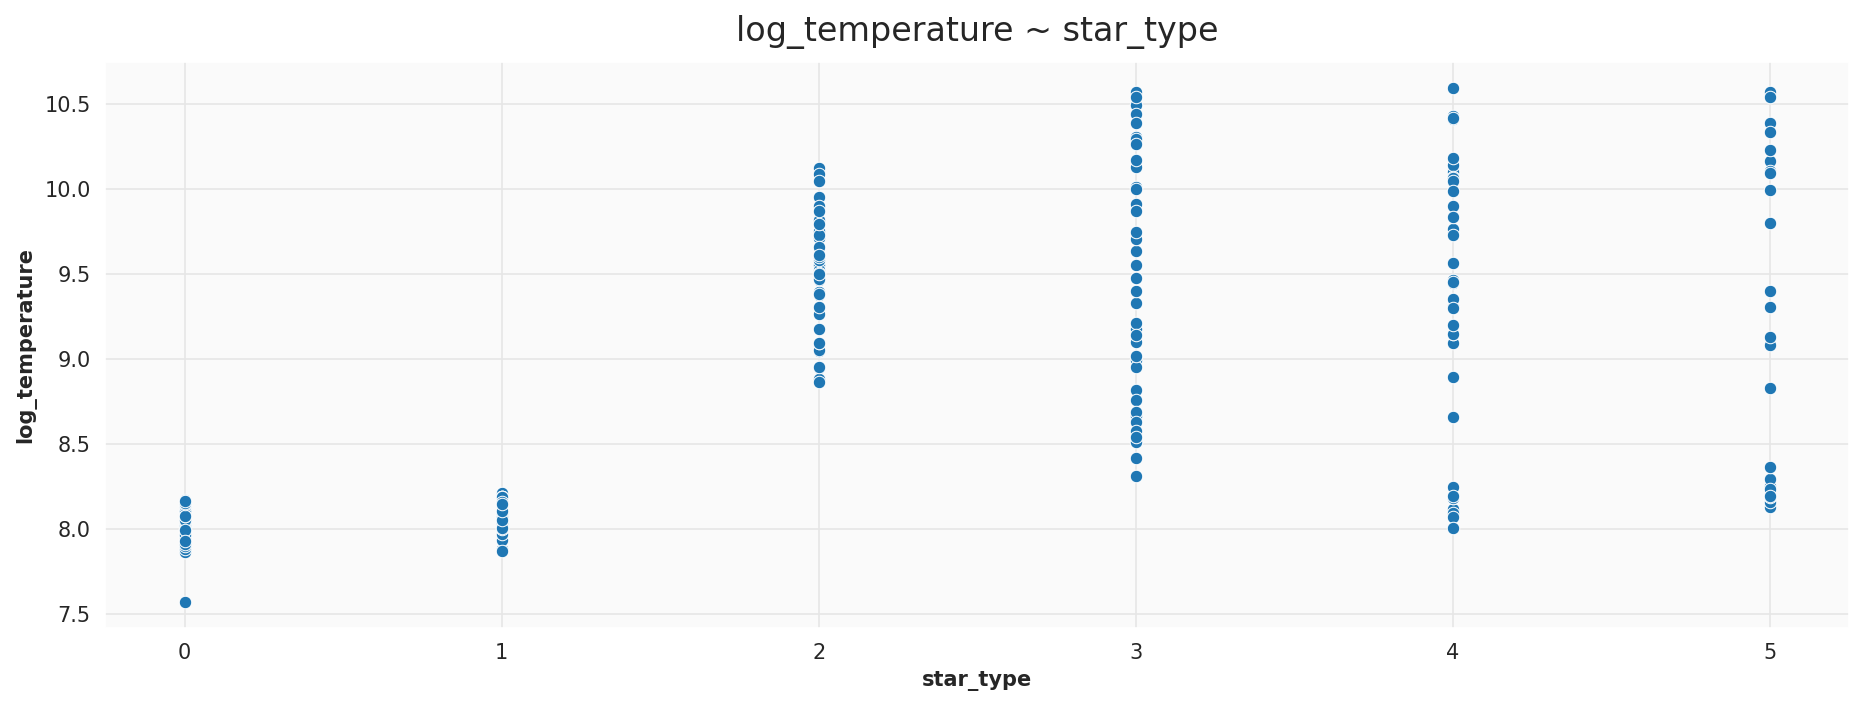

In [88]:
scatterplot_feature_target(data, 'star_type', 'temperature', func_y=np.log, prefix_y='log_')

- Типам `0` и `1` свойственен узкий диапазон температур (1 выброс таки имеется).  
- Остальные типы имеют широкий разброс температур и спектральных классов. В некторых даже наблюдаются разрывы, которые, впрочем, могут объясняться небольшим количеством наблюдений в данных.  

- Признак `Type` — категориальный, однако в нем присутствует упорядоченность: чем больше значение, тем больше радиус звезды. Поэтому можно условно считать его числовым и оставить значения как есть.  


- ***Проведем эксперимент, чтобы выяснить, как упорядоченность влияет на качество модели.***

In [89]:
# признак Color не нужен, поскольку заменен на Temp_log_avg
data = data.drop('star_color', axis=1)

### Выделение признаков и целевой переменной

In [90]:
X = data.drop('temperature', axis=1)
Y = data['temperature']

X.shape, Y.shape

((240, 5), (240,))

### Разделение на обучающую и валидационную выборки

In [91]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=RS)

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((168, 5), (168,), (72, 5), (72,))

In [92]:
# номера звезд, попавших в валидационную выборку, потребуются при построении графика качества прогноза
idx_valid = Y_valid.index

### Подготовка данных

In [93]:
cat_features = X_train.select_dtypes(exclude='number').columns
sorted(cat_features)

[]

In [94]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_exclude='number')

In [95]:
num_features = X_train.select_dtypes(include='number').columns
sorted(num_features)

['absolute_magnitude', 'luminosity', 'radius', 'star_type', 'temp_log_avg']

In [96]:
num_preprocessor = make_pipeline(
#                                  IterativeImputer(initial_strategy='mean', random_state=RS),
                                 StandardScaler(),
#                                  SplineTransformer(),
                                )

In [97]:
cat_preprocessor = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [98]:
preprocessing = make_column_transformer(
                                        (num_preprocessor, num_selector),
                                        (cat_preprocessor, cat_selector),
                                       )

In [99]:
X_train = preprocessing.fit_transform(X_train)
X_valid = preprocessing.transform(X_valid)

In [100]:
# Смотрим размеры выборок на кодированных данных OHE:
for i in [X_train, X_valid, Y_train, Y_valid]:
    print(i.shape)

(168, 5)
(72, 5)
(168,)
(72,)


### Преобразование данных в Tensor

In [101]:
X_train = torch.FloatTensor(np.array(X_train))
Y_train = torch.FloatTensor(np.array(Y_train))
X_valid = torch.FloatTensor(np.array(X_valid))
Y_valid = torch.FloatTensor(np.array(Y_valid))

### Базовая нейронноя сеть

#### Нейронная сеть

Сеть состоит из входных нейронов, двух скрытых слоев и выходного слоя:

In [102]:
class Net(nn.Module):
    def __init__(self, n_in, n_hidden_1, n_hidden_2, n_out, p_dropout=0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hidden_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_1)
        self.act1 = nn.LeakyReLU()
        self.dp2 = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_2)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_2, n_out)
        self.act3 = nn.ReLU()
        
#         nn.init.kaiming_uniform(self.fc1.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform(self.fc2.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform(self.fc2.weight, mode='fan_in', nonlinearity='relu')
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

#### Инициализация сети

In [103]:
def net_init(n_in, n_hidden_1, n_hidden_2, n_out, p_dropout=0):
    torch.manual_seed(RS)
    model = Net(n_in, n_hidden_1, n_hidden_2, n_out, p_dropout=p_dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss = nn.MSELoss()
    return model, optimizer, loss

In [104]:
n_in = X_train.shape[1]
n_hidden_1 = 64
n_hidden_2 = 16
n_out = 1

p_dropout = 0     # для простой модели Dropout не используется

model, optimizer, loss = net_init(n_in, n_hidden_1, n_hidden_2, n_out, p_dropout=p_dropout)

In [105]:
class EarlyStop():
    '''
    Выполняет остановку обучения, если значение loss function не улучшается в течение ряда эпох
    '''
    def __init__(self, patience=5, min_delta=1):
        '''
        patience: количество эпох для ожидания улучшения значения loss function
        min_delta: минимальное значение, считаемое улучшением значения loss function
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        
        if self.best_loss - val_loss >= self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter > self.patience:
                print('--- early stop ---')
                self.early_stop = True

#### Функция для обучения сети и и вывода RMSE_test

In [106]:
def net_training(n_epoch, batch_size, stop_interval=100, stop_patience=5, stop_delta=1, verbose=0):
    '''
    n_epoch: максимальное количество эпох
    batch_size: размер батча при обучении
    stop_interval: проверка раннего окончания каждые stop_interval эпох
    stop_patience: раннее окончание, если значение loss function не улучшается stop_patience последовательных проверок
    stop_delta: минимальное значение, считаемое улучшением значения loss function
    verbose: выводить инфо при каждой verbose-ой проверке раннего окончания,
             при verbose=0 промежуточная инфо не выводится
    '''
    
    stop = EarlyStop(patience=stop_patience, min_delta=stop_delta)
    
    for epoch in range(n_epoch):

        # новый DataLoader для каждой эпохи
        tds_train = torch.utils.data.TensorDataset(X_train, Y_train)
        dl_train = DataLoader(tds_train, batch_size=batch_size, shuffle=True, num_workers=0)

        model.train()

        
        for batch in dl_train:
            
            data_train, target_train = batch
            target_pred = model.forward(data_train)
            loss_train = torch.sqrt(loss(target_pred.flatten(), target_train.flatten()))    # RMSE
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()


        if epoch % stop_interval == 0:
            
            model.eval()

            with torch.no_grad():
                target_pred = model.forward(X_valid)
                loss_valid = torch.sqrt(loss(target_pred.flatten(), Y_valid.flatten()))     # RMSE

                if verbose >= 1:
#                    if (epoch % int(stop_interval * verbose) == 0):
                        print(f'epoch {epoch}, RMSE_valid = {loss_valid:.1f}')

            stop(loss_valid)
            
            if stop.counter == 0:         # фиксация лучшего результата
                best_loss = loss_valid
                best_pred = target_pred
                
            if stop.early_stop:           # сработало раннее окончание
                print(f'Best RMSE_valid = {best_loss:.1f}')
                return best_pred, best_loss

In [107]:
%%time

prediction, _ = net_training(n_epoch=15000, batch_size=40, stop_interval=50, stop_patience=20, stop_delta=1, verbose=20)

epoch 0, RMSE_valid = 12760.6
epoch 50, RMSE_valid = 12756.2
epoch 100, RMSE_valid = 12749.3
epoch 150, RMSE_valid = 12738.7
epoch 200, RMSE_valid = 12718.0
epoch 250, RMSE_valid = 12689.4
epoch 300, RMSE_valid = 12661.5
epoch 350, RMSE_valid = 12620.4
epoch 400, RMSE_valid = 12575.5
epoch 450, RMSE_valid = 12538.6
epoch 500, RMSE_valid = 12481.5
epoch 550, RMSE_valid = 12436.6
epoch 600, RMSE_valid = 12403.5
epoch 650, RMSE_valid = 12344.0
epoch 700, RMSE_valid = 12258.6
epoch 750, RMSE_valid = 12219.8
epoch 800, RMSE_valid = 12170.7
epoch 850, RMSE_valid = 12098.5
epoch 900, RMSE_valid = 12010.2
epoch 950, RMSE_valid = 11997.8
epoch 1000, RMSE_valid = 11858.2
epoch 1050, RMSE_valid = 11760.4
epoch 1100, RMSE_valid = 11726.0
epoch 1150, RMSE_valid = 11661.1
epoch 1200, RMSE_valid = 11555.2
epoch 1250, RMSE_valid = 11363.5
epoch 1300, RMSE_valid = 11317.4
epoch 1350, RMSE_valid = 11262.6
epoch 1400, RMSE_valid = 11165.6
epoch 1450, RMSE_valid = 11003.7
epoch 1500, RMSE_valid = 10981.7


- получена метрика RMSE ниже заданного порога 4500.

#### Функция для визуализации прогноза

In [108]:
def plot_prediction(Y_valid, Y_pred, func_y=passthrough, prefix_y=''):
    '''
    Визуализация качества прогноза
    Y_valid: тензор правильных ответов
    Y_pred: тензор прогноза
    func_y: функция для предварительной обработки значений по оси Y (по-умолчанию обработка не применяется)
    prefix_y: префикс для подписи оси Y
    '''

    ax_valid = func_y(Y_valid.detach().numpy())
    ax_pred = func_y(Y_pred.detach().numpy().flatten())
    
    fig, ax = plt.subplots(figsize=(len(idx_valid)/3, 6), dpi=150)
    
    sns.barplot(x=idx_valid, y=ax_valid, color='skyblue', label='Target')
    sns.barplot(x=idx_valid, y=ax_pred, color='orange', linewidth=0,alpha =0.3, label='Prediction')
    
    ax.legend()
    ax.set_title(f'{prefix_y}Temperature: Target and Prediction')
    ax.set_xlabel('Star index in source data')
    ax.set_ylabel(f'{prefix_y}Temperature, К')
    plt.show()

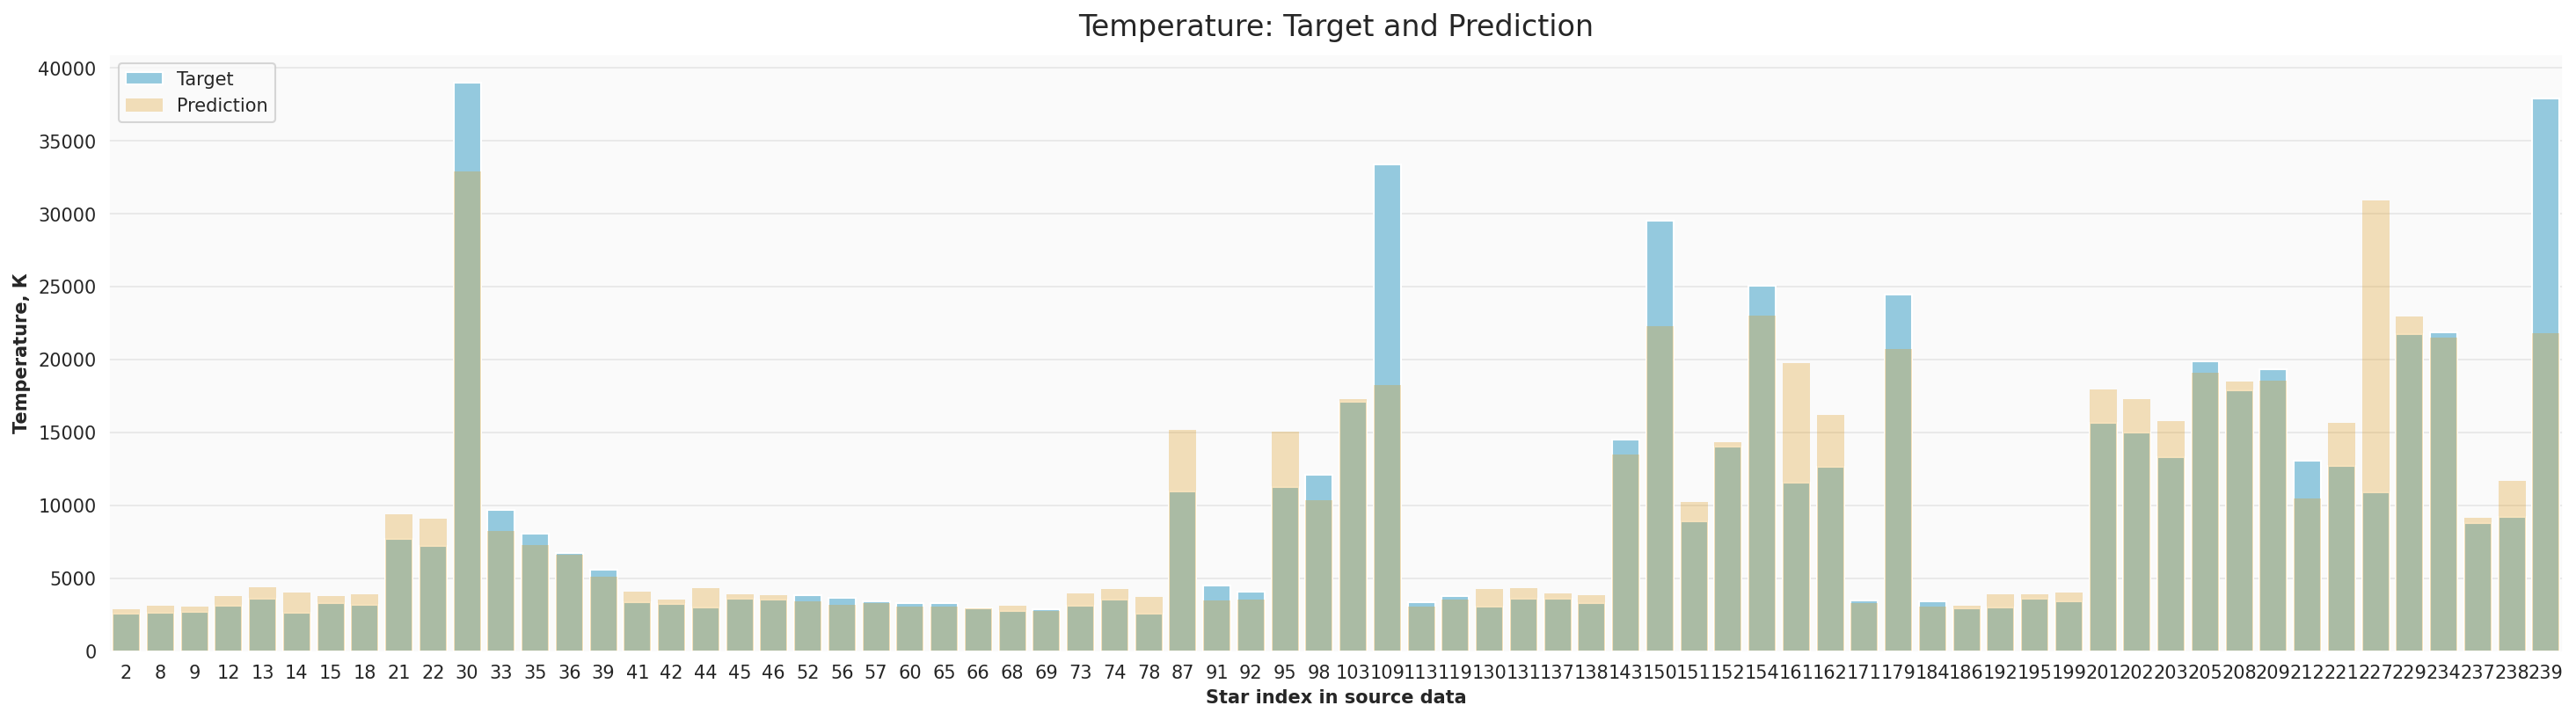

In [109]:
plot_prediction(Y_valid, prediction)

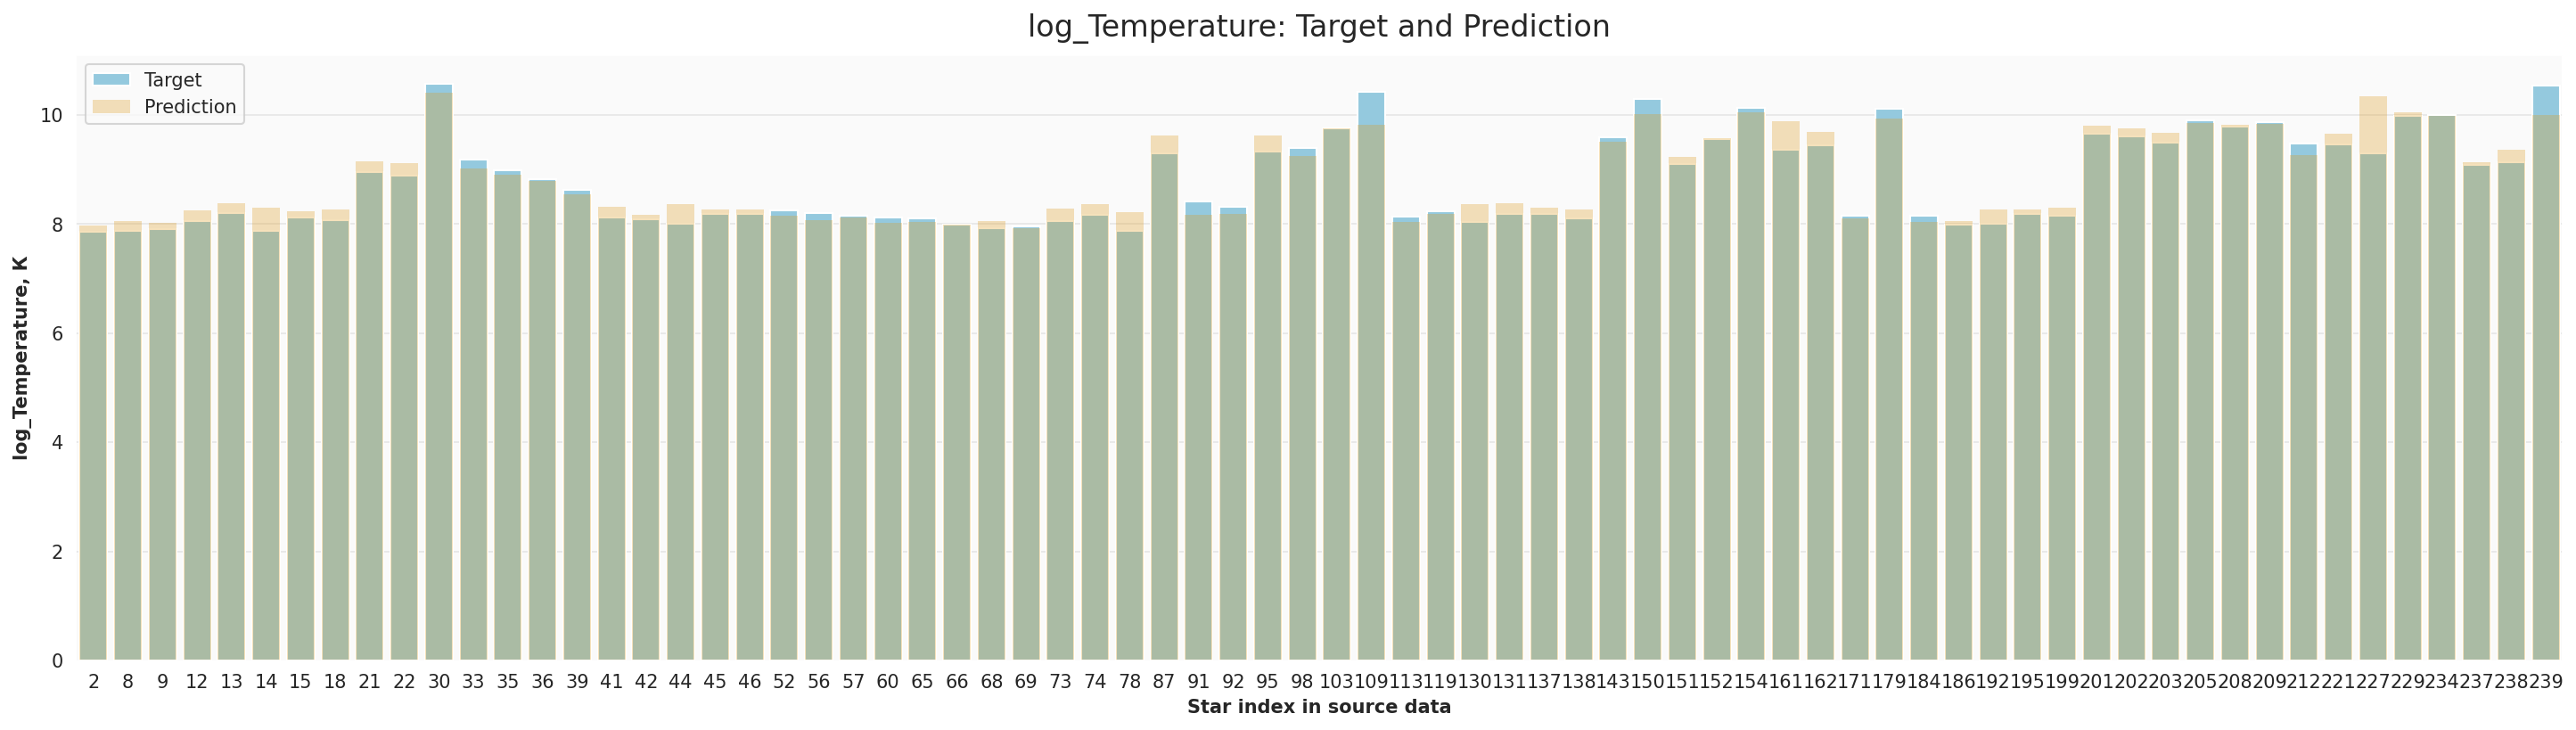

In [110]:
plot_prediction(Y_valid, prediction, func_y=np.log, prefix_y='log_')

- На некоторых звездах высокое значение ошибки. Как правило, это звезды с высокой температурой. Предсказания более точны на малых значениях температуры до 5000 К, что связано с пребладанием в исходных данных малых значений температуры, радиуса и светимостей. 
- Температура звезд изменяется в широких пределах. Ошибка в тысячу градусов Кельвина будет существенной для красной звезды и почти незаметной для синей звезды.
- С учетом этой нелинейности метрика RMSE выглядит не самой подходящей. Возможно, лучше подошла бы MAPE или другая метрика, учитывающая широкий диапазон температур.

- **На графике логарифма температуры видно, что ошибка для всех звезд примерно соизмерима.**

### Улучшение нейронной сети

#### Подбор гиперпараметров

In [111]:
%%time

CR = '\n' 

# таблица для учета результатов моделей
df = pd.DataFrame(columns=['batch_size', 'p_dropout', 'rmse', 'prediction'])

# гиперпараметры для перебора
batch_size_list = [60, 40, 20]
p_dropout_list = [0.7, 0.65, 0.6, 0.5]

for batch_size in batch_size_list:
    for p_dropout in p_dropout_list:
    
        start_time = time()
        print(f'--- batch_size={batch_size}, p_dropout={p_dropout} ---')

        # инициализация очередной модели
        model, optimizer, loss = net_init(n_in, n_hidden_1, n_hidden_2, n_out, p_dropout=p_dropout)        

        # обучение модели
        prediction, rmse = net_training(n_epoch=100000, batch_size=batch_size,
                                        stop_interval=10, stop_patience=20, stop_delta=1, verbose=100)

        print(f'time spent: {time() - start_time:.1f} sec.{CR}')

        # добавление очередного результата в таблицу
        df.loc[len(df)] = [batch_size, p_dropout, rmse.item(), prediction]

--- batch_size=60, p_dropout=0.7 ---
epoch 0, RMSE_valid = 12760.6
epoch 10, RMSE_valid = 12760.1
epoch 20, RMSE_valid = 12759.5
epoch 30, RMSE_valid = 12759.0
epoch 40, RMSE_valid = 12758.6
epoch 50, RMSE_valid = 12758.2
epoch 60, RMSE_valid = 12757.6
epoch 70, RMSE_valid = 12757.1
epoch 80, RMSE_valid = 12756.3
epoch 90, RMSE_valid = 12755.7
epoch 100, RMSE_valid = 12754.9
epoch 110, RMSE_valid = 12754.1
epoch 120, RMSE_valid = 12752.8
epoch 130, RMSE_valid = 12752.0
epoch 140, RMSE_valid = 12750.7
epoch 150, RMSE_valid = 12749.5
epoch 160, RMSE_valid = 12748.1
epoch 170, RMSE_valid = 12746.7
epoch 180, RMSE_valid = 12745.7
epoch 190, RMSE_valid = 12744.0
epoch 200, RMSE_valid = 12741.7
epoch 210, RMSE_valid = 12740.6
epoch 220, RMSE_valid = 12738.7
epoch 230, RMSE_valid = 12737.5
epoch 240, RMSE_valid = 12734.1
epoch 250, RMSE_valid = 12731.6
epoch 260, RMSE_valid = 12729.6
epoch 270, RMSE_valid = 12727.1
epoch 280, RMSE_valid = 12725.0
epoch 290, RMSE_valid = 12721.7
epoch 300, RMS

#### Таблица с результом эксперимента

In [112]:
df = df.sort_values('rmse').reset_index(drop=True)
df[['rmse','batch_size','p_dropout']]

,rmse,batch_size,p_dropout
0,3751.221,40,0.500
1,3818.284,40,0.600
2,3829.460,20,0.500
3,3838.407,20,0.600
4,3860.107,40,0.650
5,3895.382,20,0.700
6,3928.158,60,0.600
7,3943.912,60,0.650
8,3986.468,60,0.500
9,3995.391,20,0.650


   - Лучшая RMSE у модели с `batch_size=40` и `p_dropout=0.5` - 3751.221.

#### Графики качества для лучшей модели

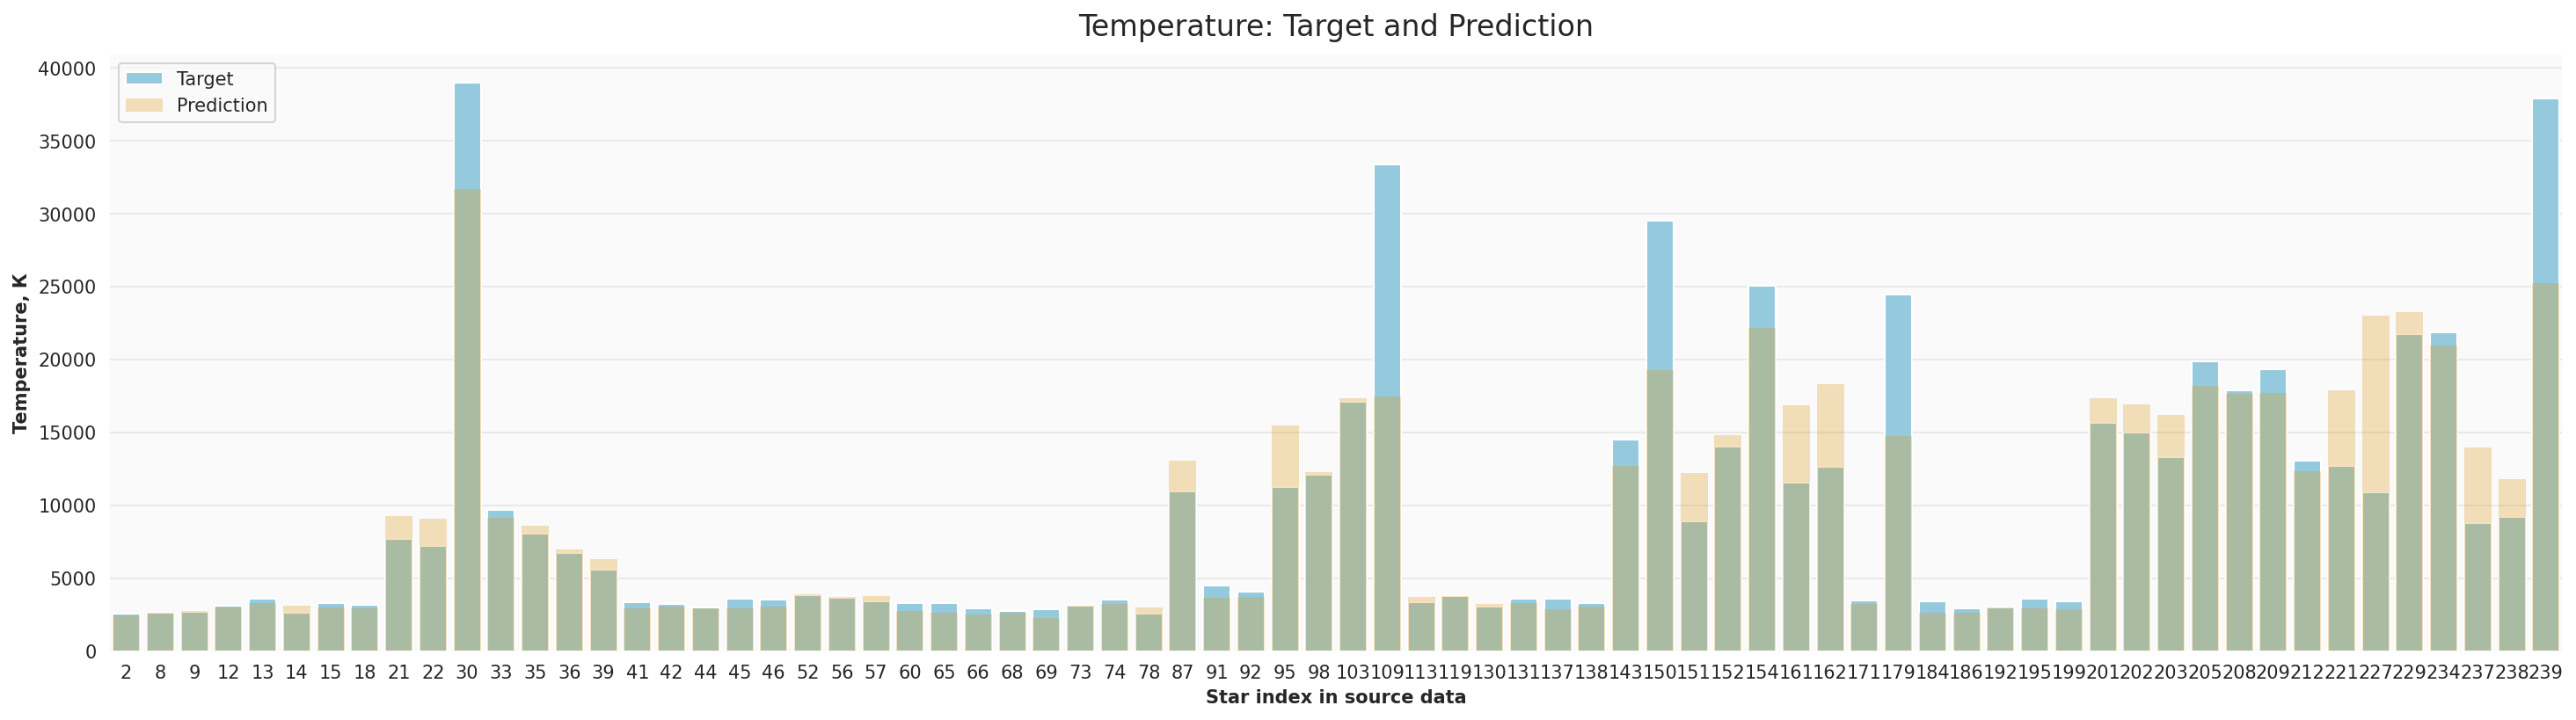

In [113]:
plot_prediction(Y_valid, df.loc[0, 'prediction'])

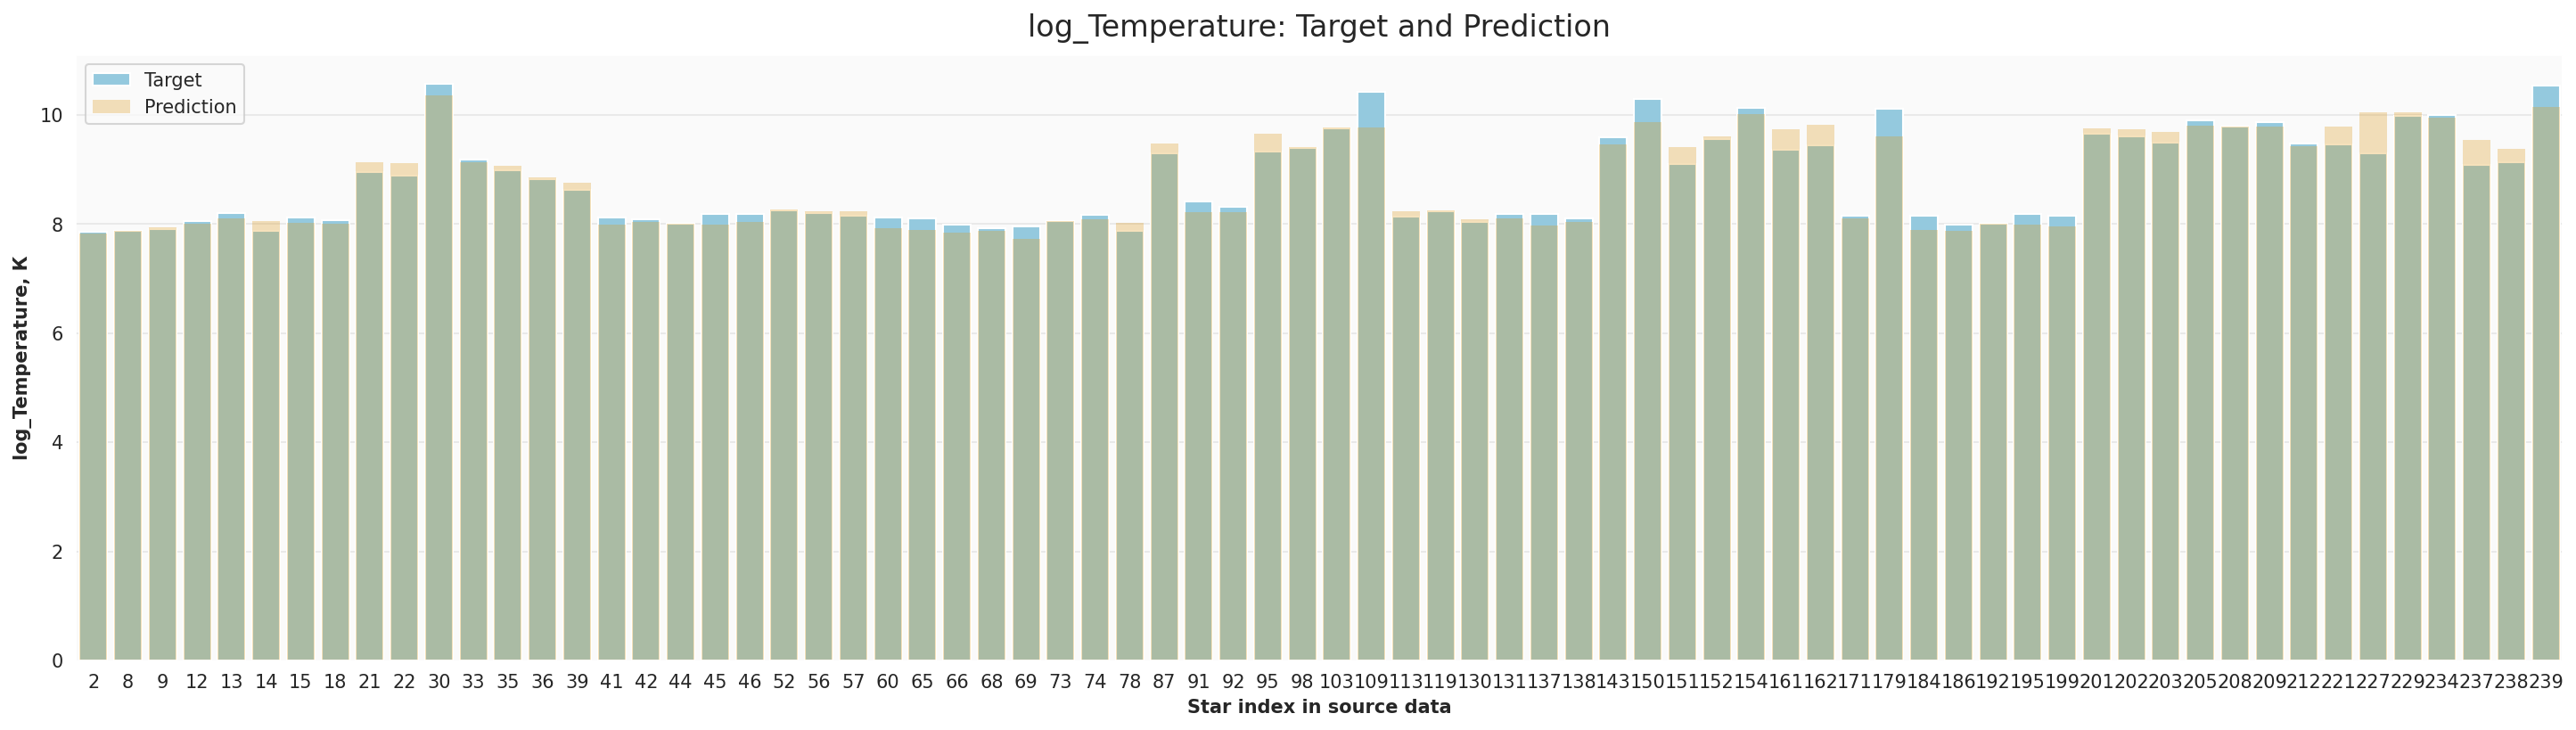

In [114]:
plot_prediction(Y_valid, df.loc[0, 'prediction'], func_y=np.log, prefix_y='log_')

 - Метрика RMSE заметно улучшилась, благодаря применению `Dropout` одновременно с `BatchNorm1d`.
 - `Dropout` оказала более существенное влияние на результат, чем размер батча.
 - Без применения `Dropout` модель имела тенденцию к улучшению при снижении размера батча (в проекте этот эксперимент не приводится). При добавлении `Dropout` тенденция изменилась, и лучшая модель имеет гиперпараметры batch_size=40 и p_dropout=0.5. Был проверен более широкий диапазон значений `batch_size` и `p_dropout`, но оставлен за рамками пректа, чтобы время для проверки работы кода оставалось в разумных пределах.

### Вывод по базовой сети 2:

 - ***Исследовательский анализ:***  
      - Выявлены и исправлены спектральные классы звезд, отсутствующие в стандартной классификации (возможно, существуют другие классификации).  
      - Исследованы зависимости целевого признака (температуры) от других признаков.    
      - Выявлено, что зависимости, как правило, нелинейные.    
      - Выявлена тенденция к образованию кластеров.
      - При исследовании признака `Star color` выявлено, что температура многих звезд, особенно классов `blue` и `red`, выходит далеко за границы, указанные в классификации. Дальнейшее исследование этой проблемы может улучшить качество модели.  
      
 - ***Подготовка данных для модели:***  
      - Решено заменить категориальный признак `Star color` числовым. Для каждого спектрального класса рассчитан средний логарифм ожидаемой температуры.  
      - Категориальный признак `Star type` решено оставить в числовом виде, поскольку упорядоченность является оправданной: чем больше значение `Star type`, тем больше диаметр звезды (судя по описанию признака).  
      - Эксперименты с моделью показали, что оба решения несколько улучшили качество модели.  
      - Создан пайплайн для подготовки данных для модели, который включает как обработку числовых, так и категориальных признаков. Это пригодится для экспериментов с созданием новых признаков.  
       
 - ***Простая модель:***  
      - Создана базовая модель (нейронная сеть), которая показала результат достаточный по условиям задания.
      - Класс, функция обучения и функция визуализации качества прогноза написаны так, чтобы их можно было использовать для последующего эксперимента по улучшению модели.  
      - RMSE на графике логарифма температуры для всех звезд примерно соизмерим.
      
 - ***Улучшенная модель:***  
      - Для улучшения модели использован подбор гиперпарамтров: размер батча обучающих данных и параметр `p` для `Dropout`.  
      - В результате созданы несколько моделей, результаты которых объединены в общую таблицу.  
      - Для лучшей модели построены графики качества прогноза.
      - RMSE на графике логарифма температуры для всех звезд примерно соизмерима.
       

---

## Выводы

- В датасете 7 столбцов и 240 записей. Типы данных: object и int64.
- Проведены анализ и предподготовка исходного набора данных для приведения значений к надлежащему виду перед построением нейронной сети, решающей поставленную задачу.
- В ходе выбора подхода к построению нейросети были изучены базовая и улучшенная нейросети. Изучение поведения данных на базовой нейросети помогло установить необходимый подход для улучшения модели.
- Исследование показало, что применение нейросети решает задачу определения температуры на поверхности звёзд. Заданный порог RMSE=4500 пройден.